## Things to adjust 

1. Scaling
2. tau diff
3. tau lim
4. Adjust link angle limits


tau_sum
foot_velocity
walking speed

In [1]:
%reset
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

import dill
dill.load_session('Biped_th0_Imotors.db')


def hide_sloution(hiddenLines):
    from IPython.core.display import display, HTML
    toggle_code_str = '''
    <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Solution: {0}"></form>
    '''.format(hiddenLines)

    toggle_code_prepare_str = '''
        <script>
        function code_toggle() {
            if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
                $('div.cell.code_cell.rendered.selected div.input').hide();
            } else {
                $('div.cell.code_cell.rendered.selected div.input').show();
            }
        }
        </script>

    '''

    display(HTML(toggle_code_prepare_str))
    display(HTML(toggle_code_str))
    
hide_sloution('Import Files')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Set parameters
h_min = 0.5
h_max = 1.0

tau_diff_lim = 7
# using the 24V values 
rated_torque = 15.0
speed_rated_torque = 23.0 
peak_torque = 38.0
no_load_speed = 27.9 

max_foot_height = 0.05

tests = {0:'High_Drop', 1:'Low_Drop', 2:'Periodic_Walk',\
         3:'Start_Periodic_Walk', 4:'Stop_Periodic_Walk'}

test = tests[2]
mu_value = 1

# NOTE: there is a link between the knee angle and unstretched leg length - kinematics
# knee = 120deg --> r = 0.45

knee_angle_max = 140 # deg
unstretched_leg_length = 0.4
speed_factor = 0.4 # Remy paper 0.4, 0.5 and 1
V_avg = speed_factor*sqrt(unstretched_leg_length*9.81)


if test == 'High_Drop' or test == 'Low_Drop':
    N = 50
    TT = 0.1
elif test == 'Start_Periodic_Walk':
    N = 50
    TT = 1.0
    #TT = xfinal/V_avg
elif test == 'Periodic_Walk':
    #     x_final = stride_length
    N = 100
    TT = 0.5 # 0.2 for optimal
elif test =='Stop_Periodic_Walk':
    N = 50
    TT = 0.3
else:
    pass


In [3]:
hide_sloution('Symbolic Imports')
func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [BLD] + [foot_angle] + [foot_length] +\
           [cg] + [lx_boom] + [ly_boom] + [N_GR] +\
           [y_boomOffset] + [y_bodyOffset] + [x_footOffset] +\
           [COMR[link,leg] for leg in legs for link in links]+\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias['body']] + [inertias['boom','X']] + [inertias['boom','Y']] + [inertias['motors']] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+ [th[link,leg] for leg in legs for link in links] +\
           [dx_body]+[dy_body]+[dth[link,leg] for leg in legs for link in links] +\
           [ddx_body]+[ddy_body] + [ddth[link,leg] for leg in legs for link in links] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for leg in legs:
    for link in links:
        DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


In [4]:
hide_sloution('Parameters')
# PARAMETERS:

COMR_ = {'ULA': 41.14/174.5,
         'LLA': 132.2/300,
         'URA': 41.14/174.5,
         'LRA': 190.4/295.5,
         'ULB': 41.14/174.5,
         'LLB': 132.2/300,
         'URB': 41.14/174.5,         
         'LRB': 190.4/295.5}

masses_ = {'body': 5756.78/1000,
           'boom': 2470.66/1000,
           'ULA': 153.81/1000,
           'LLA': 346.45/1000,
           'URA': 153.81/1000,
           'LRA': 499.95/1000,
           'ULB': 153.81/1000,
           'LLB': 346.45/1000,
           'URB': 153.81/1000,
           'LRB': 499.95/1000}

lengths_ = {'body': 253/1000,
            'boom': None,
            'ULA': 174.5/1000,
            'LLA': 300.0/1000,
            'URA': 174.5/1000,
            'LRA': 295.5/1000,
            'ULB': 174.5/1000,
            'LLB': 300.0/1000,
            'URB': 174.5/1000,
            'LRB': 295.5/1000}

inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'boom_X': 1947254622.19*1e-9,
             'boom_Y': 1947254622.19*1e-9,
             'motors': 181877.41*1e-9,
             'ULA': 600933.68*1e-9, # rotates as pendulumn
             'LLA': 4659658.63*1e-9,
             'URA': 600933.68*1e-9,
             'LRA': 7369968.50*1e-9,
             'ULB': 600933.68*1e-9, # rotates as pendulumn 
             'LLB': 4659658.63*1e-9,
             'URB': 600933.68*1e-9,
             'LRB': 7369968.50*1e-9}

all_links = []
all_links_inertia = []
leg_links = []
[leg_links.append(link+leg) for leg in legs for link in links]
[all_links.append(base) for base in bases]
[all_links.append(link+leg) for leg in legs for link in links]
all_links_inertia.append('body')
all_links_inertia.append('boom_X')
all_links_inertia.append('boom_Y')
all_links_inertia.append('motors')
[all_links_inertia.append(link+leg) for leg in legs for link in links]


total_mass = 0.0
for mass in masses_: # must equal ~ 9.1 - 9.5kg
    if mass == 'boom':
        total_mass += masses_[mass]*0.5
    else:
        total_mass += masses_[mass]
print("Mass must equal 9.1 - 9.5kg, current mass value = ",total_mass)


WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] + [m.N_GR] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] + [m.inertias['motors']]+\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] + [m.N_GR] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] + [m.inertias['motors']]+\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



Mass must equal 9.1 - 9.5kg, current mass value =  9.30015


--------------
Stall torque =  85.40816326530614
Max speed =  27.9
--------------


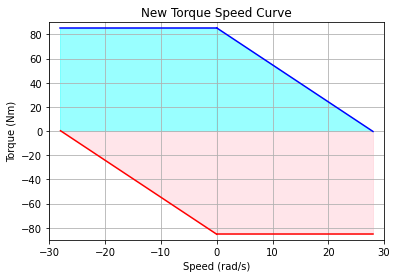

In [5]:
hide_sloution('Torque Speed Curve Display')

'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, int(no_load_speed+1), num=int(no_load_speed+1))
x_n = np.linspace(-int(no_load_speed+1), 0, num=int(no_load_speed+1))

# using the 24V values 
rated_torque = 15.0
speed_rated_torque = 23.0 
peak_torque = 38.0
no_load_speed = 27.9 

m_grad = (rated_torque-0.0)/(speed_rated_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(peak_torque)
    rated_torque_n.append(-peak_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-30,30,-90,90))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [6]:
hide_sloution('Integration')
m = ConcreteModel('Biped_th0_Imotors')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.leg_links = Set(initialize = leg_links)
m.all_links_inertia = Set(initialize = all_links_inertia)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)

#FixedParams--------------------------
m.g = Param(initialize = 9.81)
m.BLD = Param(initialize = 60/1000)
m.foot_angle = Param(initialize = 135*(np.pi/180))
m.foot_length = Param(initialize = 42.5/1000)
m.cg = Param(initialize = 1.149)
m.lx_boom = Param(initialize = 2.575)
m.ly_boom = Param(initialize = 2.493)
m.y_boomOffset = Param(initialize = 0.101)
m.y_bodyOffset = Param(initialize = 8.36/1000)
m.x_footOffset = Param(initialize = 1.63/1000)
m.N_GR = Param(initialize = 9)


m.COMR = Param(m.leg_links, initialize = COMR_)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links_inertia, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (h_min,h_max)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lengths) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/uct/anaconda3/envs/test-ipopt/lib/python3.9/site-
    packages/pyomo/core/base/param.py:77)


In [7]:
hide_sloution('Connection Constraint')
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [8]:
hide_sloution('Ground Contact Constraints')
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = mu_value,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(foot_position['right',leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] <= m.ground_penalty[n,'contact',leg]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg] <= m.ground_penalty[n,'friction',leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg] <= m.ground_penalty[n,'slip_+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg] <= m.ground_penalty[n,'slip_-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

#bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


In [9]:
hide_sloution('Torque Speed Curve Constraint')
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-peak_torque,peak_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_TW_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.TW_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_right)

def def_TW_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.TW_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_left)



In [10]:
# hide_sloution('Limit Torque Difference')
# def def_max_change_torque(m,n,side,leg):
#     if n<(N-1):
#         return abs(m.tau_torque[n+1,side,leg] - m.tau_torque[n,side,leg]) <= tau_diff_lim
#     else:
#         return abs(m.tau_torque[n,side,leg] - m.tau_torque[n-1,side,leg]) <= tau_diff_lim
# m.max_change_torque = Constraint(m.N, m.sides, m.legs, rule = def_max_change_torque)

In [11]:
hide_sloution('Knee Angle Limit')
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,knee_angle_max*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_LL'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_LR'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [12]:
hide_sloution('Mark Periodic Constraints')
# Get the foot position in WDOF
# if test == "Periodic_Walk" or test == "Periodic_Hop":
    
#     lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
#     m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

#     # CONSTRAINTS
#     def def_body_position(m,n,wdof):
#         var_list = get_var_list_zeros(m,n)
#         if wdof == 'X':
#             return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
#         else: return Constraint.Skip
#     m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
#     if test == "Periodic_Walk":
        
# #         def def_hold_foot(m,n):
# #             return m.foot_position[1,'X','B'] - m.foot_position[N,'X','B'] == 0
# #         m.def_hold_foot_constraint = Constraint(m.N, rule = def_hold_foot)
# #         def def_foot_velocity(m,n,wdof,leg):
# #             if wdof == 'Y':
# #                 return m.foot_velocity[1,'Y','+ve',l]-m.foot_velocity[n,'Y','-ve',leg] == 0
# #             else: return Constraint.Skip
# #         m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)
    
    
#         # Average velocities
#         def def_body_position_average(m,wdof):
#             if wdof == 'X':
#                 return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
#             else: return Constraint.Skip
#         m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
#         # Equate states
#         def def_equate_position_states(m,n,dof_i):
            
#             if dof_i == 'y_body':
#                 return m.q[1,dof_i] == m.q[N,dof_i]
            
#             elif dof_i == 'theta_ULA':
#                 return m.q[1,'theta_ULA'] == m.q[N,'theta_ULB']
#             elif dof_i == 'theta_ULB':
#                 return m.q[1,'theta_ULB'] == m.q[N,'theta_ULA']
            
#             elif dof_i == 'theta_URA':
#                 return m.q[1,'theta_URA'] == m.q[N,'theta_URB']
#             elif dof_i == 'theta_URB':
#                 return m.q[1,'theta_URB'] == m.q[N,'theta_URA']
            
#             elif dof_i == 'theta_LLA':
#                 return m.q[1,'theta_LLA'] == m.q[N,'theta_LLB']
#             elif dof_i == 'theta_LLB':
#                 return m.q[1,'theta_LLB'] == m.q[N,'theta_LLA']
            
#             elif dof_i == 'theta_LRA':
#                 return m.q[1,'theta_LRA'] == m.q[N,'theta_LRB']

# #             elif dof_i == 'theta_ULA':
# #                 return m.q[1,'theta_ULA'] == m.q[N,'theta_ULA']
# #             elif dof_i == 'theta_ULB':
# #                 return m.q[1,'theta_ULB'] == m.q[N,'theta_ULB']
            
# #             elif dof_i == 'theta_URA':
# #                 return m.q[1,'theta_URA'] == m.q[N,'theta_URA']
# #             elif dof_i == 'theta_URB':
# #                 return m.q[1,'theta_URB'] == m.q[N,'theta_URB']
            
# #             elif dof_i == 'theta_LLA':
# #                 return m.q[1,'theta_LLA'] == m.q[N,'theta_LLA']
# #             elif dof_i == 'theta_LLB':
# #                 return m.q[1,'theta_LLB'] == m.q[N,'theta_LLB']
            
# #             elif dof_i == 'theta_LRA':
# #                 return m.q[1,'theta_LRA'] == m.q[N,'theta_LRA']
            
# #             elif dof_i == 'theta_LRB':
# #                 return m.q[1,'theta_LRB'] == m.q[N,'theta_LRB']
#             else: 
#                  return Constraint.Skip
#         m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
#         def def_equate_vel_states(m,n,dof_i):
#             return m.dq[1,dof_i] == m.dq[N,dof_i]
#         m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
#         # Condition where the GRF can't increase twice from zero          
    
    
#     else: 
        
#         def def_equate_position_states(m,n,dof_i):
#             return m.q[1,dof_i] == m.q[N,dof_i]
#         m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
#         def def_equate_vel_states(m,n,dof_i):
#             return m.dq[1,dof_i] == m.dq[N,dof_i]
#         m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

# else: pass
                                    


In [13]:
hide_sloution('Periodic Constraints')
# Get the foot position in WDOF
if test == "Periodic_Walk" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_bases['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Walk":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            
            elif dof_i == 'theta_ULA':
                return m.q[1,'theta_ULA'] == m.q[N,'theta_ULB']
            elif dof_i == 'theta_ULB':
                return m.q[1,'theta_ULB'] == m.q[N,'theta_ULA']
            
            elif dof_i == 'theta_URA':
                return m.q[1,'theta_URA'] == m.q[N,'theta_URB']
            elif dof_i == 'theta_URB':
                return m.q[1,'theta_URB'] == m.q[N,'theta_URA']
            
            elif dof_i == 'theta_LLA':
                return m.q[1,'theta_LLA'] == m.q[N,'theta_LLB']
            elif dof_i == 'theta_LLB':
                return m.q[1,'theta_LLB'] == m.q[N,'theta_LLA']
            
            elif dof_i == 'theta_LRA':
                return m.q[1,'theta_LRA'] == m.q[N,'theta_LRB']
#             elif dof_i == 'theta_LRB':
#                 return m.q[1,'theta_LRB'] == m.q[N,'theta_LRA']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs, rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
        # Condition where the GRF can't increase twice from zero          
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [14]:
#test code
hide_sloution('Initial Conditions')
sign_symbols = ['+','-']
boundaries = ['setub','setlb']

for n in range(1,N+1):
    for leg in legs:
        for index in range(len(boundaries)):
            eval('m.q[n,\'theta_UL\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
            eval('m.q[n,\'theta_LL\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
            eval('m.q[n,\'theta_UR\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
            eval('m.q[n,\'theta_LR\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))


# for n in range(1,N+1):    
    if test == 'High_Drop' or test == 'Low_Drop':
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
            
    else:
        x_low_lim = -1.0
        x_high_lim = 2.0
        y_low_lim = -0.5
        y_high_lim = 1.5
        
        if test == 'Periodic_Walk' or test == 'Periodic_Walk_Stop':
            pass
        else:
            # test == 'Start_Periodic_Walk'
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        

In [15]:
if test == 'High_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(1.0)


    m.q[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Low_Drop':
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'y_body'].fix(0.5)
    
    m.q[1,'theta_ULA'].fix(np.pi*(0.5-1/7))
    m.q[1,'theta_URA'].fix(np.pi*(0.5+1/7))

    m.q[1,'theta_ULB'].fix(np.pi*(0.5-1/10))
    m.q[1,'theta_URB'].fix(np.pi*(0.5+1/10))
    
elif test == 'Periodic_Walk':
    # Approach: begin and end in stance
    guide = np.linspace(0,TT*V_avg,N)
    
    m.q[1,'x_body'].setlb(-1.0)
    m.q[1,'x_body'].setub(1.0)
    m.foot_position[1,'Y','A'].fix(0.00)
    m.foot_position[1,'Y','B'].fix(0.00)
    m.foot_position[int(N/2),'Y','A'].setlb(0.05)
    
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1]
        
        # Added on
        m.foot_position[n,'Y','B'].fix(0.00)
        if n<int(N/2)-int(N*0.3) or n>int(N/2)+int(N*0.3):
            m.foot_position[n,'Y','A'].fix(0.00)
            
    def def_zero_velocityA(m,n):
        if n==1:
            return m.foot_velocity[n,'X','+ve','A']-m.foot_velocity[n,'X','-ve','A'] == 0.00
        else:
            return Constraint.Skip
    m.def_zero_velocityA_constraint = Constraint(m.N, rule = def_zero_velocityA)
    
    def def_zero_velocityB(m,n):
        if n>0:
            return m.foot_velocity[n,'X','+ve','B']-m.foot_velocity[n,'X','-ve','B'] == 0.00
        else:
            return Constraint.Skip
    m.def_zero_velocityB_constraint = Constraint(m.N, rule = def_zero_velocityB)
    
    def def_zero_velocity_end(m,n):
        if n>int(N/2)+int(N*0.3):
            return m.foot_velocity[n,'X','+ve','A']-m.foot_velocity[n,'X','-ve','A'] == 0.00
        else:
            return Constraint.Skip
    m.def_zero_velocity_end_constraint = Constraint(m.N, rule = def_zero_velocity_end)
            
else:
    pass

In [16]:
hide_sloution('Worked Solutions')

#     def def_mirror_foot(m,n):
#         if n>1 and n<int(N/2)-int(0.3*N):
#             return m.foot_position[n,'Y','B'] - m.foot_position[N-n,'Y','A'] <=0.01
#         else: return Constraint.Skip
#     m.def_mirror_foot_constraint = Constraint(m.N, rule = def_mirror_foot)



# elif test == "Periodic_Walk":
# #     # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# #     guide = np.linspace(0,TT*V_avg,N)
# #     for n in range(1,N+1):
# #         m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25) 
# #     def def_hold_xposition(m,n):
# #         # maintain x-foot position up to 0.01m
# #         if n < int(N/4):
# #             return  m.foot_position[n+1, 'X', 'B'] - m.foot_position[n, 'X', 'B'] <= 0.01
# #         else:
# #             return Constraint.Skip
# #     m.def_hold_xposition_constraint = Constraint(m.N,rule = def_hold_xposition)

# #     m.q[1,'x_body'].fix(0.0) # initial condition


#     m.GRF_y[n,'A'].fix(0.0)
#     for n in range (1,int(N/4)):
#         m.foot_position[n,'X','B'].fix(0.0)
            
    
# #     for n in range(1,N+1):
# #         m.foot_position[n, 'Y', 'A'].setub(max_foot_height)
# #         m.foot_position[n, 'Y', 'B'].setub(max_foot_height)
        
# #         if n < int(N/4):   
# #             m.foot_position[n,'X','B'].fix(0.0)
# #             m.GRF_y[n,'A'].fix(0.0)


#         m.q[n,'y_body'].setlb(0.3)
        
#         if n < (int(N/2)):
#             m.GRF_y[n,'B'].setlb(50)
#             m.GRF_y[n,'A'].fix(0.0)
#             m.foot_position[n,'X','B'].fix(0.0)        
#         else:
#             pass
    
    
#     guide = np.linspace(0,TT*V_avg,N)
#     m.foot_position[1,'X','A'].fix(0.00)
#     m.foot_position[1,'Y','A'].setlb(0.05)
    
#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
        
#         if n < (int(N/2)+5):
#             m.GRF_y[n,'B'].setlb(50)
#             m.GRF_y[n,'A'].fix(0.0)
#             m.foot_position[n,'X','B'].fix(0.0)        
# #         elif n > (int(N/2)+5) and n < (int(N/2)+10):
# #             m.foot_position[n,'Y','B'].setlb(0.01)
# #             m.foot_position[n,'Y','B'].setub(0.03)
            
#         elif n > (int(N/2)-5):
#             m.GRF_y[n,'A'].setlb(50)
#         elif n < (int(N/2)-5) and n > (int(N/2)-10):
#             m.foot_position[n,'Y','A'].setlb(0.01)
#             m.foot_position[n,'Y','A'].setub(0.03)

#         else:
#             pass

In [17]:
hide_sloution('Mark Periodic Conditions')

# elif test == 'Start_Periodic_Walk':
#     #init conditions
#     #match mid walk node1 conditions
#     with open('periodic_walk_N1_data_v10.pkl','rb') as f:
#         start_data = pickle.load(f)
    
# #     guide = np.linspace(0,TT*V_avg,N)
#     for n in range(1,N+1):
#         m.q[n,'y_body'].setub(0.5)
#         m.q[n,'x_body'].setub(1.0)
#         m.q[n,'x_body'].setlb(0.0)
# #         m.foot_position[n,'X','A'].setlb(0.0)
# #         m.foot_position[n,'X','B'].setlb(0.0)
# #         m.foot_position[n,'Y','A'].setub(0.06)
# #         m.foot_position[n,'Y','B'].setub(0.06)

# #         m.q[n,'x_body'].setub(1.0)
# #         m.q[n,'x_body'].value = guide[n-1]
        
#     m.q[1,'x_body'].fix(0.0)

    
#     m.foot_position[1,'X','A'].fix(0.0)
#     m.foot_position[1,'X','B'].fix(0.0)
#     m.foot_position[1,'Y','A'].fix(0.0)
#     m.foot_position[1,'Y','B'].fix(0.0)
    
# #     m.foot_position[N/2,'Y','A'].fix(0.0)
# #     m.foot_position[N/2,'Y','B'].fix(0.0)
    
# #     m.foot_position[N,'Y','B'].fix(0.0)
    
# #     for n in range(1,N+1):
# #         if n<(N/2):
# # #             m.foot_position[n,'Y','B'].fix(0.0)
# # #             m.foot_position[n,'X','B'].fix(0.0)
# # #             m.GRF_y[n,'B'].fix(0.0)
# #             m.GRF_y[n,'A'].setlb(0.1)
# # # #             m.foot_position[n,'X','A'].fix(0.0)
    
# #             if n>1:
# #                 m.GRF_y[n,'B'].fix(0.0)

# #         elif n>(N/2):
# #             m.GRF_y[n,'A'].fix(0.0)
# #             m.foot_position[n,'Y','B'].fix(0.0)
# #             if n>(N-10):
# #                 m.foot_position[n,'Y','A'].setlb(0.02)

    
#     m.q[N,'y_body'].fix(start_data['ybod'])
#     m.dq[N,'y_body'].fix(start_data['dybod'])
#     m.dq[N,'x_body'].fix(start_data['dxbod'])
    
#     m.q[N,'theta_ULA'].fix(start_data['thULA'])
#     m.q[N,'theta_LLA'].fix(start_data['thLLA'])
#     m.q[N,'theta_URA'].fix(start_data['thURA'])
#     m.q[N,'theta_LRA'].fix(start_data['thLRA'])
    
#     m.q[N,'theta_ULB'].fix(start_data['thULB'])
#     m.q[N,'theta_LLB'].fix(start_data['thLLB'])
#     m.q[N,'theta_URB'].fix(start_data['thURB'])
#     m.q[N,'theta_LRB'].fix(start_data['thLRB'])
    
#     m.dq[N,'theta_ULA'].fix(start_data['dthULA'])
#     m.dq[N,'theta_LLA'].fix(start_data['dthLLA'])
#     m.dq[N,'theta_URA'].fix(start_data['dthURA'])
#     m.dq[N,'theta_LRA'].fix(start_data['dthLRA'])
    
#     m.dq[N,'theta_ULB'].fix(start_data['dthULB'])
#     m.dq[N,'theta_LLB'].fix(start_data['dthLLB'])
#     m.dq[N,'theta_URB'].fix(start_data['dthURB'])
#     m.dq[N,'theta_LRB'].fix(start_data['dthLRB'])
    
    

# elif test == 'Periodic_Walk':
#     guide = np.linspace(0,TT*V_avg,N)

#     for n in range(1,N+1):
#         m.q[n,'x_body'].value = guide[n-1]
#         m.q[n,'y_body'].setub(0.42)

#     m.foot_position[1,'Y','B'].fix(0.0)
    
#     m.q[1,'x_body'].fix(0.0)


    
#     m.foot_position[N/2,'Y','A'].fix(0.0)
#     m.foot_position[N/2,'Y','B'].fix(0.0)
    
#     for n in range(1,N+1):
#         if n<(N/2):
#             m.GRF_y[n,'A'].fix(0.0)
#             m.GRF_y[n,'B'].setlb(1)
#             m.foot_position[n,'X','B'].fix(0.0)
            
#             if n<(N/2 - 5):
#                 m.foot_position[n,'Y','A'].setlb(0.04)
#                 m.foot_position[n,'Y','A'].setub(0.06)
                
#         elif n>(N/2):
#             m.GRF_y[n,'B'].fix(0.0)
#             m.GRF_y[n,'A'].setlb(1)
            
#             if n>(N/2 + 15):
#                 m.foot_position[n,'Y','B'].setlb(0.04)
#                 m.foot_position[n,'Y','B'].setub(0.06)
                

#         else:
#             pass
            
#     m.foot_position[N,'Y','A'].fix(0.0)
    

    
# elif test == 'Periodic_Walk_Stop':
    
#     with open('periodic_walk_mid_v1.pkl','rb') as f:
#         start_data = pickle.load(f)
    
#     m.q[1,'y_body'].fix(start_data['ybod'])
#     m.dq[1,'x_body'].fix(start_data['dxbod'])
    
#     m.dq[1,'theta_ULA'].fix(start_data['dthULA'])
#     m.dq[1,'theta_LLA'].fix(start_data['dthLLA'])
#     m.dq[1,'theta_URA'].fix(start_data['dthURA'])
#     m.dq[1,'theta_LRA'].fix(start_data['dthLRA'])
    
#     m.dq[1,'theta_ULB'].fix(start_data['dthULB'])
#     m.dq[1,'theta_LLB'].fix(start_data['dthLLB'])
#     m.dq[1,'theta_URB'].fix(start_data['dthURB'])
#     m.dq[1,'theta_LRB'].fix(start_data['dthLRB'])
    
#     m.q[1,'x_body'].fix(0.0) # initial condition

# #     m.q[1,'y_body'].fix(body_height)
    

# #     m.dq[1,'y_body'].fix(0.0)

#     m.foot_position[1,'X','A'].fix(0.0-(stride_length/2))
#     m.foot_position[1,'X','B'].fix(0.0+(stride_length/2))
#     m.foot_position[1,'Y','A'].fix(0.0)
#     m.foot_position[1,'Y','B'].fix(0.0)
# #     m.q[1,'y_body'].fix(body_height)
    
#     for n in range(1,N+1):
#         m.foot_position[n,'X','B'].fix(stride_length/2)
#         m.foot_position[n,'Y','B'].fix(0.0)
    
#     for n5 in range(N-5,N+1): # last 5 nodes 
#         for dof_i in DOFs:
#             if dof_i == 'x_body':
#                 m.dq[n5,dof_i].setub(0.0)
#             else:
#                 pass
# #                 m.dq[n5,dof_i].setub(0.05*m.dq[1,dof_i])
                
#         m.foot_position[n5, 'Y', 'A'].fix(0.0)
#         m.foot_position[n5, 'Y', 'B'].fix(0.0)
        
#     m.q[N,'x_body'].fix(stride_length/2)
# #     m.q[N,'y_body'].fix(body_height)

    
#     m.dq[N,'x_body'].fix(0.0)
#     m.dq[N,'y_body'].fix(0.0)

    
#     m.dq[N,'theta_ULA'].fix(0.0)
#     m.dq[N,'theta_URA'].fix(0.0)
#     m.dq[N,'theta_LLA'].fix(0.0)
#     m.dq[N,'theta_LRA'].fix(0.0)
    
#     m.dq[N,'theta_ULB'].fix(0.0)
#     m.dq[N,'theta_URB'].fix(0.0)
#     m.dq[N,'theta_LLB'].fix(0.0)
#     m.dq[N,'theta_LRB'].fix(0.0)
    
    
    
#     m.foot_position[N,'X','A'].fix(stride_length/2)
#     m.foot_position[N,'X','B'].fix(stride_length/2)
    
    
    
# #     m.foot_position[N,'X','A'].fix(0.75)
# #     m.foot_position[N,'X','B'].fix(0.25)
    
# else:
#     pass


In [18]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 #row = 1e3 # scale the penalty
    tau_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    tau_diff = 0.0
    foot_diff = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            if n<N:
                foot_diff += (m.foot_position[n+1,'Y',leg] - m.foot_position[n,'Y',leg])**2
            for side in sides:
                tau_sum += (m.tau_torque[n,side,leg])**2 # m.h[n]*(m.tau_torque[n,side,leg])**2
                #tau_diff = sum(diff(m.tau_torque[n,side,leg]))
                if n<N:
                    tau_diff += (m.tau_torque[n+1,side,leg])**2 - m.tau_torque[n,side,leg]**2
            for gc in ground_constraints:
                for leg in legs:
                    pen_sum += m.ground_penalty[n,gc,leg] 
                    
    return row*pen_sum + tau_sum + tau_diff/10  #return row*pen_sum + tau_sum/10 #+ tau_diff
m.Cost = Objective(rule = CostFun)

In [19]:
hide_sloution('Lambdify EOMs')

''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_ULA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULA'](*var_list) == 0
m.EOM_th_ULA_constraint = Constraint(m.N, rule = EOM_th_ULA)

def EOM_th_LLA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLA'](*var_list) == 0
m.EOM_th_LLA_constraint = Constraint(m.N, rule = EOM_th_LLA)

def EOM_th_URA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URA'](*var_list) == 0
m.EOM_th_URA_constraint = Constraint(m.N, rule = EOM_th_URA)

def EOM_th_LRA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRA'](*var_list) == 0
m.EOM_th_LRA_constraint = Constraint(m.N, rule = EOM_th_LRA)

def EOM_th_ULB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULB'](*var_list) == 0
m.EOM_th_ULB_constraint = Constraint(m.N, rule = EOM_th_ULB)

def EOM_th_LLB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLB'](*var_list) == 0
m.EOM_th_LLB_constraint = Constraint(m.N, rule = EOM_th_LLB)

def EOM_th_URB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URB'](*var_list) == 0
m.EOM_th_URB_constraint = Constraint(m.N, rule = EOM_th_URB)

def EOM_th_LRB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRB'](*var_list) == 0
m.EOM_th_LRB_constraint = Constraint(m.N, rule = EOM_th_LRB)

In [20]:
# solving
#opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
bambi = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt'
lenovo = '/home/zubair/build/bin/ipopt'
opt = SolverFactory(bambi)
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*20   # maximum number of iterations
opt.options["max_cpu_time"] = 600*20 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.2: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=600000
max_cpu_time=12000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    36501
Number of nonzeros in inequality constraint Jacobian.:     3912
Number of nonzeros in Lagrangian Hessian.............:    24669

Total number of variables............................:     7855
                     variables with only lower bounds:      661
                variables with lower and upper bounds:     3895
                     variables with only 

 115r 1.8734494e+07 1.62e+00 2.02e+02  -0.5 8.76e-01   1.0 3.64e-01 1.84e-01f  1
 116r 1.8725207e+07 1.62e+00 2.45e+02  -0.5 8.90e+00   0.5 1.96e-01 1.25e-01f  1
 117r 1.8718317e+07 1.62e+00 3.14e+02  -0.5 2.47e+00   0.9 5.01e-01 2.68e-01f  1
 118r 1.8713807e+07 1.61e+00 1.82e+02  -0.5 8.69e-01   1.4 1.00e+00 5.46e-01f  1
 119r 1.8711008e+07 1.61e+00 2.12e+01  -0.5 3.45e-01   1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 1.8707592e+07 1.61e+00 1.25e+02  -0.5 2.29e+00   1.3 4.74e-01 6.09e-01f  1
 121r 1.8703035e+07 1.61e+00 1.01e+02  -0.5 1.76e+00   1.7 5.80e-01 9.32e-01f  1
 122r 1.8701128e+07 1.60e+00 1.34e+02  -0.5 9.36e-01   2.2 1.00e+00 9.76e-01f  1
 123r 1.8700743e+07 1.60e+00 1.62e+02  -0.5 4.75e-01   2.6 1.00e+00 5.82e-01f  1
 124r 1.8700457e+07 1.60e+00 2.66e+02  -0.5 4.34e+00   2.1 1.96e-01 1.23e-01f  1
 125r 1.8700461e+07 1.60e+00 1.16e+03  -0.5 3.50e+00   1.6 5.45e-01 4.85e-03f  1
 126r 1.8696928e+07 1.60e+00

 252r 1.5767469e+07 1.48e+00 2.65e+02  -1.2 2.48e+00   1.5 9.41e-02 2.22e-01f  1
 253r 1.5766858e+07 1.48e+00 6.59e+02  -1.2 4.94e+01   1.1 3.34e-03 9.16e-03f  1
 254r 1.5766824e+07 1.48e+00 9.46e+02  -1.2 2.79e+00   1.5 1.39e-01 1.24e-03f  1
 255r 1.5750596e+07 1.48e+00 7.47e+02  -1.2 2.13e+00   1.0 1.06e-01 2.05e-01f  1
 256r 1.5747108e+07 1.48e+00 7.24e+02  -1.2 2.29e+01   0.5 6.31e-03 1.55e-02f  1
 257r 1.5728345e+07 1.48e+00 5.70e+02  -1.2 2.77e+00   1.0 2.14e-01 2.13e-01f  1
 258r 1.5713115e+07 1.48e+00 5.35e+02  -1.2 3.26e+01   0.5 6.56e-02 6.10e-02f  1
 259r 1.5666926e+07 1.48e+00 2.96e+02  -1.2 4.72e+00   0.9 3.21e-01 4.75e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260r 1.5645665e+07 1.48e+00 1.24e+02  -1.2 1.66e+00   1.3 5.74e-01 5.81e-01f  1
 261r 1.5640280e+07 1.48e+00 1.52e+02  -1.2 8.04e+00   0.9 1.72e-01 5.16e-02f  1
 262r 1.5604563e+07 1.48e+00 3.92e+01  -1.2 2.06e+00   1.3 7.84e-01 8.96e-01f  1
 263r 1.5592463e+07 1.48e+00

 390r 1.5017016e+07 1.43e+00 5.11e+02  -1.2 2.25e+00   1.6 1.00e+00 9.76e-03f  1
 391r 1.4988760e+07 1.42e+00 6.18e+02  -1.2 3.08e+00   1.2 1.69e-01 8.22e-01f  1
 392r 1.4985390e+07 1.42e+00 1.85e+02  -1.2 1.26e+00   1.6 6.88e-01 2.64e-01f  1
 393r 1.4977719e+07 1.42e+00 1.44e+02  -1.2 6.03e+00   1.1 1.50e-01 2.44e-01f  1
 394r 1.4965502e+07 1.42e+00 1.70e+02  -1.2 1.77e+00   1.5 4.72e-01 1.00e+00f  1
 395r 1.4965138e+07 1.42e+00 1.84e+02  -1.2 6.31e+01   1.1 1.77e-03 2.19e-02f  1
 396r 1.4965103e+07 1.42e+00 2.60e+02  -1.2 3.70e+00   1.5 1.00e+00 2.88e-03f  1
 397r 1.4955031e+07 1.41e+00 1.02e+02  -1.2 1.06e+01   1.0 3.00e-01 4.50e-01f  1
 398r 1.4955055e+07 1.41e+00 2.02e+02  -1.2 4.70e+00   1.4 1.46e-01 8.06e-03f  1
 399r 1.4945542e+07 1.41e+00 1.67e+02  -1.2 2.30e+00   0.9 4.59e-01 3.70e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r 1.4945214e+07 1.40e+00 2.32e+02  -1.2 8.09e+00   0.5 1.28e-01 4.21e-02f  1
 401r 1.4939614e+07 1.40e+00

 529r 1.6577771e+07 8.88e-01 2.58e+02  -1.2 2.45e+00   1.2 2.30e-01 2.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r 1.6578959e+07 8.87e-01 2.44e+02  -1.2 2.83e+01   0.8 5.98e-02 3.74e-02f  1
 531r 1.6586536e+07 8.85e-01 2.26e+02  -1.2 4.05e+00   1.2 5.61e-02 2.46e-01f  1
 532r 1.6587787e+07 8.84e-01 2.24e+02  -1.2 1.32e+00   1.6 5.91e-01 9.15e-02f  1
 533r 1.6587826e+07 8.84e-01 3.70e+02  -1.2 2.74e-01   2.0 2.44e-01 3.03e-02f  1
 534r 1.6588339e+07 8.84e-01 2.68e+02  -1.2 9.93e-02   2.5 3.21e-01 2.95e-01f  1
 535r 1.6589159e+07 8.83e-01 4.25e+02  -1.2 3.13e-01   2.0 2.49e-01 5.97e-01f  1
 536r 1.6590822e+07 8.82e-01 3.01e+01  -1.2 1.17e-01   2.4 1.00e+00 1.00e+00f  1
 537r 1.6593182e+07 8.80e-01 9.24e+01  -1.2 3.67e-01   1.9 3.29e-01 6.11e-01f  1
 538r 1.6594223e+07 8.80e-01 2.28e+02  -1.2 1.37e-01   2.4 8.63e-01 6.67e-01f  1
 539r 1.6594811e+07 8.79e-01 3.14e+01  -1.2 5.14e-02   2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 666r 1.5751786e+07 7.46e-01 3.89e+02  -1.2 2.53e+01   0.9 6.15e-02 3.62e-02f  1
 667r 1.5750486e+07 7.46e-01 3.44e+02  -1.2 1.09e+00   1.3 8.73e-02 2.25e-02f  1
 668r 1.5739050e+07 7.46e-01 3.25e+02  -1.2 5.61e+00   0.8 6.02e-02 6.13e-02f  1
 669r 1.5732055e+07 7.46e-01 2.77e+02  -1.2 1.37e+00   1.3 1.14e-01 1.04e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r 1.5718980e+07 7.46e-01 3.09e+02  -1.2 1.01e+01   0.8 1.11e-02 6.33e-02f  1
 671r 1.5717168e+07 7.46e-01 2.68e+02  -1.2 1.96e+00   1.2 7.87e-02 2.27e-02f  1
 672r 1.5692933e+07 7.46e-01 2.19e+02  -1.2 5.04e+01   0.7 2.64e-02 5.51e-02f  1
 673r 1.5691631e+07 7.46e-01 5.07e+02  -1.2 3.43e+00   1.2 1.49e-01 1.09e-02f  1
 674r 1.5673783e+07 7.46e-01 4.66e+02  -1.2 4.13e+00   0.7 4.02e-02 4.52e-02f  1
 675r 1.5662088e+07 7.46e-01 4.25e+02  -1.2 1.24e+00   1.1 1.11e-01 9.89e-02f  1
 676r 1.5657040e+07 7.45e-01 3.93e+02  -1.2 1.22e+00   1.5 3.93e-02 1.19e-01f  1
 677r 1.5656075e+07 7.45e-01

 759r 1.4512981e+07 6.44e-01 4.53e+02  -1.2 3.24e+00   0.8 3.05e-02 9.29e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r 1.4500822e+07 6.44e-01 4.09e+02  -1.2 9.52e-01   1.2 1.16e-01 2.57e-01f  1
 761r 1.4488527e+07 6.44e-01 8.35e+01  -1.2 9.16e-01   1.6 1.00e+00 7.88e-01f  1
 762r 1.4488437e+07 6.44e-01 3.08e+02  -1.2 5.41e+00   1.1 1.39e-01 1.96e-03f  1
 763r 1.4485728e+07 6.44e-01 2.26e+02  -1.2 9.49e-01   1.6 4.61e-01 1.57e-01f  1
 764r 1.4464596e+07 6.42e-01 2.61e+02  -1.2 1.64e+00   1.1 9.56e-01 4.22e-01f  1
 765r 1.4451621e+07 6.42e-01 7.57e+01  -1.2 6.03e-01   1.5 7.85e-01 7.14e-01f  1
 766r 1.4407096e+07 6.39e-01 4.68e+01  -1.2 3.17e+00   1.0 6.52e-01 8.09e-01f  1
 767r 1.4406611e+07 6.39e-01 1.18e+03  -1.2 1.26e+00   1.5 1.00e+00 2.19e-02f  1
 768r 1.4394680e+07 6.38e-01 3.56e+02  -1.2 7.34e-01   1.0 7.62e-02 1.92e-01f  1
 769r 1.4387874e+07 6.38e-01 2.90e+02  -1.2 2.07e+00   1.4 7.40e-01 2.94e-01f  1
iter    objective    inf_pr 

 896r 1.3882121e+07 6.20e-01 1.92e+02  -1.2 2.38e+00   1.3 3.11e-02 5.42e-02f  1
 897r 1.3882211e+07 6.20e-01 1.80e+02  -1.2 7.63e-01   1.8 1.20e-01 8.63e-02f  1
 898r 1.3882242e+07 6.20e-01 1.76e+02  -1.2 5.24e+00   1.3 1.44e-02 1.87e-02f  1
 899r 1.3882575e+07 6.20e-01 5.64e+02  -1.2 9.57e-01   1.7 7.61e-02 3.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r 1.3882836e+07 6.20e-01 6.11e+02  -1.2 1.99e+01   1.2 1.44e-02 3.98e-02f  1
 901r 1.3882840e+07 6.20e-01 6.91e+02  -1.2 1.90e+00   1.7 8.79e-01 4.11e-03f  1
 902r 1.3882770e+07 6.20e-01 6.50e+02  -1.2 6.94e-01   1.2 5.14e-02 5.69e-02f  1
 903r 1.3878670e+07 6.20e-01 5.66e+02  -1.2 2.95e+00   0.7 1.61e-01 1.39e-01f  1
 904r 1.3878090e+07 6.20e-01 4.88e+02  -1.2 8.93e-01   1.1 1.41e-01 1.38e-01f  1
 905r 1.3869781e+07 6.20e-01 5.29e+02  -1.2 4.64e+00   0.6 7.03e-01 2.54e-01f  1
 906r 1.3868875e+07 6.20e-01 4.31e+02  -1.2 1.56e+00   1.1 9.94e-01 1.78e-01f  1
 907r 1.3867715e+07 6.20e-01

1034r 1.3582547e+07 6.14e-01 2.34e+02  -1.2 2.20e+00   1.4 2.85e-01 1.35e-01f  1
1035r 1.3581223e+07 6.14e-01 9.50e+02  -1.2 4.01e+00   0.9 1.38e-01 5.84e-02f  1
1036r 1.3580257e+07 6.14e-01 5.38e+02  -1.2 2.63e+00   1.4 5.93e-03 1.16e-01f  1
1037r 1.3579982e+07 6.22e-01 5.56e+02  -1.2 9.36e-01   1.8 3.16e-01 1.89e-01f  1
1038r 1.3579886e+07 6.22e-01 4.98e+02  -1.2 1.59e+00   1.3 2.02e-01 1.29e-02f  1
1039r 1.3579807e+07 6.22e-01 5.49e+02  -1.2 8.63e+00   0.8 6.96e-02 4.67e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040r 1.3579381e+07 6.22e-01 3.16e+02  -1.2 1.19e+00   1.3 8.69e-01 7.81e-02f  1
1041r 1.3577279e+07 6.20e-01 2.55e+02  -1.2 3.72e+00   0.8 1.88e-01 2.19e-01f  1
1042r 1.3575522e+07 6.15e-01 3.45e+02  -1.2 1.17e+00   1.2 7.83e-02 4.25e-01f  1
1043r 1.3574676e+07 6.15e-01 4.08e+02  -1.2 2.13e+01   0.7 3.61e-02 5.15e-02f  1
1044r 1.3574657e+07 6.15e-01 1.05e+03  -1.2 1.70e+00   1.2 3.25e-01 6.46e-03f  1
1045r 1.3574433e+07 6.15e-01

1172r 1.3597781e+07 6.25e-01 2.81e+02  -1.2 6.31e-01   1.5 5.39e-01 2.29e-02f  1
1173r 1.3601489e+07 6.25e-01 1.95e+02  -1.2 3.12e+00   1.0 6.91e-02 2.42e-01f  1
1174r 1.3601804e+07 6.25e-01 3.17e+02  -1.2 9.55e-01   1.4 4.71e-01 2.61e-02f  1
1175r 1.3604661e+07 6.25e-01 2.45e+02  -1.2 7.40e+00   1.0 6.12e-02 1.53e-01f  1
1176r 1.3605197e+07 6.25e-01 3.83e+02  -1.2 1.81e+00   1.4 4.22e-01 3.53e-02f  1
1177r 1.3611324e+07 6.25e-01 1.62e+02  -1.2 5.00e-01   1.8 1.72e-01 1.00e+00f  1
1178r 1.3612948e+07 6.25e-01 1.37e+02  -1.2 2.49e+00   1.3 3.16e-01 2.21e-01f  1
1179r 1.3612936e+07 6.25e-01 1.36e+02  -1.2 9.66e+01   0.9 4.76e-03 5.25e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180r 1.3612745e+07 6.25e-01 1.51e+03  -1.2 2.47e+00   1.3 2.58e-01 3.55e-02f  1
1181r 1.3614516e+07 6.25e-01 7.85e+02  -1.2 6.50e-01   1.7 1.01e-01 5.83e-01f  1
1182r 1.3615593e+07 6.25e-01 3.83e+01  -1.2 2.75e-01   2.1 7.93e-01 1.00e+00f  1
1183r 1.3615796e+07 6.25e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310r 6.9944479e+06 4.73e-02 1.28e+03  -6.3 2.36e+01  -3.3 4.75e-02 5.53e-02h  1
1311r 7.0201541e+06 4.73e-02 1.28e+03  -6.3 7.48e+01  -3.8 1.07e-02 2.36e-03h  1
1312r 7.0299213e+06 4.73e-02 1.28e+03  -6.3 3.26e+02    -  2.28e-02 1.89e-03h  1
1313r 7.0890988e+06 4.72e-02 1.26e+03  -6.3 3.25e+02    -  1.27e-02 1.16e-02f  1
1314r 7.1329313e+06 4.72e-02 1.25e+03  -6.3 2.58e+01  -3.3 1.65e-01 1.14e-02h  1
1315r 7.2381054e+06 4.72e-02 1.24e+03  -6.3 7.30e+01  -3.8 3.38e-03 1.07e-02h  1
1316r 7.2457876e+06 4.72e-02 1.24e+03  -6.3 5.46e+02    -  4.62e-03 4.45e-04h  1
1317r 7.3132322e+06 4.71e-02 1.21e+03  -6.3 3.56e+02    -  5.14e-02 1.71e-02f  1
1318r 7.3861261e+06 4.69e-02 1.19e+03  -6.3 3.45e+02    -  4.30e-03 2.09e-02f  1
1319r 7.4262067e+06 4.69e-02 1.18e+03  -6.3 5.30e+01  -3.4 4.56e-02 9.18e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320r 7.6183266e+06 4.69e-02

1402r 1.4589690e+07 4.64e-02 9.62e+02  -6.3 2.97e+01  -3.2 3.03e-02 8.37e-03h  1
1403r 1.4740212e+07 4.65e-02 8.81e+02  -6.3 1.01e+03  -3.7 1.16e-04 1.97e-03f  1
1404r 1.4849113e+07 4.65e-02 8.25e+02  -6.3 3.43e+01  -3.3 1.20e-02 3.59e-02f  1
1405r 1.4962599e+07 4.65e-02 7.17e+02  -6.3 1.24e+01  -2.9 8.10e-02 1.18e-01f  1
1406r 1.4996158e+07 4.65e-02 7.27e+02  -6.3 4.02e+01  -3.3 2.31e-02 8.14e-03h  1
1407r 1.5012583e+07 4.65e-02 7.21e+02  -6.3 1.40e+01  -2.9 3.27e-02 1.50e-02h  1
1408r 1.5014692e+07 4.65e-02 7.12e+02  -6.3 4.57e+01  -3.4 1.88e-02 4.06e-04h  1
1409r 1.5057069e+07 4.65e-02 6.93e+02  -6.3 1.56e+01  -3.0 2.62e-02 3.40e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410r 1.5108968e+07 4.66e-02 6.91e+02  -6.3 5.41e+01  -3.4 5.89e-03 7.49e-03h  1
1411r 1.5189738e+07 4.66e-02 6.59e+02  -6.3 1.75e+01  -3.0 4.79e-02 5.63e-02h  1
1412r 1.5333582e+07 4.66e-02 6.94e+02  -6.3 7.92e+01  -3.5 4.17e-04 1.31e-02f  1
1413r 1.5386884e+07 4.66e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540r 2.0040901e+07 4.72e-02 8.14e+02  -6.3 2.87e+00  -2.3 4.17e-01 4.42e-02f  1
1541r 2.0063640e+07 4.72e-02 7.73e+02  -6.3 7.96e+00  -2.7 5.17e-02 2.05e-02f  1
1542r 2.0092346e+07 4.72e-02 7.74e+02  -6.3 3.45e+03  -3.2 3.48e-04 1.52e-04f  1
1543r 2.0094571e+07 4.72e-02 7.72e+02  -6.3 2.19e+01  -2.8 1.72e-03 1.76e-03f  1
1544r 2.0135577e+07 4.72e-02 6.78e+02  -6.3 3.44e+00  -2.4 1.52e-01 9.96e-02f  1
1545r 2.0184593e+07 4.72e-02 7.80e+02  -6.3 1.18e+01  -2.8 9.40e-02 3.28e-02f  1
1546r 2.0215825e+07 4.72e-02 1.11e+03  -6.3 3.77e+00  -2.4 1.87e-01 6.81e-02h  1
1547r 2.0278449e+07 4.73e-02 1.06e+03  -6.3 1.47e+01  -2.9 4.50e-02 3.64e-02f  1
1548r 2.0278453e+07 4.73e-02 1.08e+03  -6.3 4.21e+00  -2.5 6.14e-02 8.74e-06h  1
1549r 2.0364648e+07 4.73e-02 1.03e+03  -6.3 1.88e+01  -2.9 4.47e-02 4.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550r 2.0415388e+07 4.73e-02

1678r 2.2624041e+07 4.85e-02 4.13e+02  -6.3 2.28e+00  -2.2 6.39e-02 2.44e-02h  1
1679r 2.2618424e+07 4.85e-02 3.94e+02  -6.3 1.54e+01  -2.7 8.21e-03 1.15e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680r 2.2615641e+07 4.85e-02 3.90e+02  -6.3 2.89e+00  -2.2 8.42e-02 2.60e-02h  1
1681r 2.2608551e+07 4.85e-02 3.80e+02  -6.3 2.80e+01  -2.7 2.06e-03 9.65e-03f  1
1682r 2.2598546e+07 4.85e-02 3.75e+02  -6.3 2.10e+01  -3.2 1.29e-02 1.23e-02f  1
1683r 2.2588968e+07 4.85e-02 3.73e+02  -6.3 5.61e+01  -3.7 7.61e-03 3.90e-03f  1
1684r 2.2581468e+07 4.85e-02 3.73e+02  -6.3 1.44e+02  -4.1 2.69e-03 1.15e-03f  1
1685r 2.2573268e+07 4.85e-02 3.72e+02  -6.3 6.35e+02  -4.6 8.07e-04 4.54e-04f  1
1686r 2.2563849e+07 4.85e-02 3.72e+02  -6.3 3.29e+03  -5.1 1.62e-04 1.26e-04f  1
1687r 2.2559606e+07 4.85e-02 3.60e+02  -6.3 7.46e+04  -5.6 1.86e-05 2.80e-06f  1
1688r 2.2536922e+07 4.85e-02 3.43e+02  -6.3 1.57e+04  -6.0 1.44e-04 6.23e-05f  1
1689r 2.2534721e+07 4.85e-02

1816r 2.1288243e+07 4.87e-02 7.29e+02  -6.3 8.97e-01  -1.7 3.98e-02 8.56e-02f  1
1817r 2.1282831e+07 4.87e-02 7.14e+02  -6.3 2.67e+00  -2.2 2.63e-02 2.03e-02f  1
1818r 2.1276417e+07 4.87e-02 6.76e+02  -6.3 9.91e-01  -1.8 1.72e-01 5.43e-02h  1
1819r 2.1265129e+07 4.87e-02 6.45e+02  -6.3 4.31e+00  -2.3 1.54e-02 4.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820r 2.1249569e+07 4.87e-02 5.69e+02  -6.3 1.12e+00  -1.8 1.08e-01 1.18e-01f  1
1821r 2.1249458e+07 4.87e-02 5.68e+02  -6.3 1.17e+01  -2.3 3.30e-03 2.49e-03f  1
1822r 2.1239691e+07 4.87e-02 5.29e+02  -6.3 1.18e+00  -1.9 1.02e-01 6.84e-02f  1
1823r 2.1237140e+07 4.87e-02 5.19e+02  -6.3 3.29e+00  -2.4 8.81e-03 1.94e-02f  1
1824r 2.1220977e+07 4.87e-02 4.54e+02  -6.3 1.34e+00  -1.9 1.66e-01 1.24e-01f  1
1825r 2.1220256e+07 4.87e-02 4.45e+02  -6.3 3.51e+00  -2.4 4.50e-03 1.99e-02f  1
1826r 2.1204219e+07 4.87e-02 3.93e+02  -6.3 1.49e+00  -2.0 7.08e-02 1.18e-01f  1
1827r 2.1199084e+07 4.87e-02

1953r 2.0135322e+07 4.83e-02 4.68e+02  -6.3 1.62e+00  -2.1 5.14e-02 7.10e-06h  1
1954r 2.0131318e+07 4.83e-02 4.58e+02  -6.3 7.04e+00  -2.6 3.87e-02 2.08e-02f  1
1955r 2.0119313e+07 4.83e-02 4.25e+02  -6.3 1.81e+00  -2.1 1.43e-02 7.12e-02f  1
1956r 2.0117008e+07 4.83e-02 4.13e+02  -6.3 6.99e-01  -1.7 8.43e-02 2.83e-02h  1
1957r 2.0115774e+07 4.83e-02 4.11e+02  -6.3 3.23e+00  -2.2 5.05e-02 3.99e-03f  1
1958r 2.0110452e+07 4.83e-02 3.91e+02  -6.3 8.82e-01  -1.8 3.50e-02 5.05e-02f  1
1959r 2.0109441e+07 4.83e-02 6.32e+02  -6.3 3.42e+00  -2.2 3.60e-02 2.87e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960r 2.0107507e+07 4.83e-02 6.00e+02  -6.3 9.62e-01  -1.8 5.66e-03 1.61e-02h  1
1961r 2.0103827e+07 4.83e-02 6.60e+02  -6.3 3.21e+00  -2.3 2.80e-02 1.07e-02f  1
1962r 2.0094794e+07 4.83e-02 5.84e+02  -6.3 1.07e+00  -1.9 3.86e-02 6.76e-02f  1
1963r 2.0093096e+07 4.83e-02 5.89e+02  -6.3 3.87e+00  -2.3 6.35e-03 3.96e-03f  1
1964r 2.0088836e+07 4.83e-02

2091r 1.9414524e+07 4.76e-02 7.41e+02  -6.3 1.74e+00  -2.0 2.42e-02 2.46e-02f  1
2092r 1.9413336e+07 4.76e-02 7.44e+02  -6.3 5.96e+01  -2.5 3.15e-03 8.67e-04f  1
2093r 1.9411866e+07 4.76e-02 1.63e+03  -6.3 1.99e+00  -2.0 5.72e-02 7.21e-03f  1
2094r 1.9409578e+07 4.76e-02 1.35e+03  -6.3 6.76e-01  -1.6 1.24e-01 3.05e-02f  1
2095r 1.9402295e+07 4.75e-02 1.38e+03  -6.3 2.29e+00  -2.1 8.71e-03 3.34e-02f  1
2096r 1.9389284e+07 4.75e-02 1.35e+03  -6.3 7.73e-01  -1.7 6.12e-02 1.55e-01f  1
2097r 1.9387327e+07 4.75e-02 1.29e+03  -6.3 3.04e+00  -2.1 2.95e-02 7.91e-03f  1
2098r 1.9386248e+07 4.75e-02 1.23e+03  -6.3 8.07e-01  -1.7 3.07e-02 1.24e-02h  1
2099r 1.9385626e+07 4.75e-02 1.58e+03  -6.3 4.86e+01  -2.2 5.45e-03 4.44e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100r 1.9383638e+07 4.75e-02 1.53e+03  -6.3 9.45e-01  -1.8 2.73e-02 1.78e-02h  1
2101r 1.9381762e+07 4.75e-02 1.16e+03  -6.3 3.44e-01  -1.3 2.55e-01 4.46e-02h  1
2102r 1.9378787e+07 4.75e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230r 1.8761922e+07 4.62e-02 2.42e+02  -6.3 5.69e-01  -1.5 8.19e-02 5.10e-02f  1
2231r 1.8753736e+07 4.62e-02 2.23e+02  -6.3 1.86e+00  -2.0 3.53e-02 8.00e-02f  1
2232r 1.8750103e+07 4.62e-02 2.48e+02  -6.3 6.46e-01  -1.5 4.51e-02 8.65e-02f  1
2233r 1.8747417e+07 4.62e-02 1.70e+02  -6.3 2.38e-01  -1.1 2.10e-01 1.66e-01f  1
2234r 1.8741076e+07 4.61e-02 2.71e+02  -6.3 7.31e-01  -1.6 1.99e-02 1.38e-01f  1
2235r 1.8739798e+07 4.61e-02 6.30e+02  -6.3 2.69e-01  -1.2 3.36e-01 7.29e-02f  1
2236r 1.8739183e+07 4.61e-02 6.75e+02  -6.3 8.24e-01  -1.6 6.32e-02 1.23e-02f  1
2237r 1.8737108e+07 4.61e-02 6.24e+02  -6.3 2.95e-01  -1.2 1.06e-01 9.72e-02f  1
2238r 1.8733532e+07 4.61e-02 7.15e+02  -6.3 9.05e-01  -1.7 2.44e-02 5.75e-02f  1
2239r 1.8733490e+07 4.61e-02 6.96e+02  -6.3 4.61e+00  -2.2 6.20e-03 2.15e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2240r 1.8732287e+07 4.61e-02

2367r 1.8474919e+07 4.46e-02 7.59e+02  -6.3 1.41e+00  -1.8 9.30e-02 8.38e-05f  1
2368r 1.8474067e+07 4.46e-02 7.69e+02  -6.3 5.18e-01  -1.4 6.81e-02 2.50e-02f  1
2369r 1.8471264e+07 4.46e-02 7.68e+02  -6.3 1.60e+00  -1.9 3.01e-02 2.36e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370r 1.8471264e+07 4.46e-02 7.66e+02  -6.3 5.98e-01  -1.5 1.64e-02 2.66e-07h  2
2371r 1.8456247e+07 4.45e-02 7.05e+02  -6.3 1.84e+00  -1.9 2.34e-02 8.62e-02f  1
2372r 1.8456241e+07 4.45e-02 7.05e+02  -6.3 2.24e+01  -2.4 6.52e-05 1.21e-05h  1
2373r 1.8456194e+07 4.45e-02 7.04e+02  -6.3 1.88e+01  -2.0 2.93e-03 2.20e-04f  1
2374r 1.8455720e+07 4.45e-02 7.03e+02  -6.3 5.00e+01  -2.5 2.11e-03 7.94e-04f  1
2375r 1.8453621e+07 4.45e-02 6.91e+02  -6.3 2.38e+00  -2.0 3.98e-02 9.95e-03f  1
2376r 1.8450184e+07 4.45e-02 6.62e+02  -6.3 8.48e-01  -1.6 4.11e-02 4.11e-02f  1
2377r 1.8444476e+07 4.45e-02 6.43e+02  -6.3 2.91e+00  -2.1 2.89e-02 2.41e-02f  1
2378r 1.8443843e+07 4.45e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2460r 1.8286140e+07 4.41e-02 1.23e+03  -6.3 2.36e-01  -1.0 4.95e-02 8.75e-02f  1
2461r 1.8285495e+07 4.41e-02 1.22e+03  -6.3 7.10e-01  -1.5 5.52e-02 9.77e-03f  1
2462r 1.8284680e+07 4.41e-02 1.22e+03  -6.3 2.32e+00  -2.0 1.46e-02 4.46e-03f  1
2463r 1.8284562e+07 4.41e-02 1.22e+03  -6.3 7.17e-01  -1.6 3.31e-02 1.62e-03h  1
2464r 1.8279157e+07 4.41e-02 1.18e+03  -6.3 2.21e+00  -2.1 9.77e-03 2.58e-02f  1
2465r 1.8278512e+07 4.41e-02 1.18e+03  -6.3 3.14e+01  -2.5 4.11e-03 1.25e-03f  1
2466r 1.8277999e+07 4.41e-02 1.18e+03  -6.3 2.48e+00  -2.1 3.64e-02 2.22e-03f  1
2467r 1.8272639e+07 4.41e-02 1.11e+03  -6.3 1.01e+00  -1.7 1.15e-01 5.82e-02f  1
2468r 1.8263645e+07 4.41e-02 1.07e+03  -6.3 3.83e+00  -2.2 1.67e-02 3.56e-02f  1
2469r 1.8260578e+07 4.41e-02 1.06e+03  -6.3 3.25e+01  -2.6 7.21e-03 1.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2470r 1.8258223e+07 4.41e-02

2552  1.6013766e+05 1.04e-02 6.79e+03  -1.0 1.03e+00   0.2 6.55e-01 3.46e-01h  1
2553  1.5823154e+05 7.81e-03 8.28e+03  -1.0 2.62e+00  -0.3 3.20e-01 2.47e-01f  1
2554  1.5552795e+05 7.03e-03 7.31e+03  -1.0 9.67e+00  -0.8 8.97e-02 9.21e-02f  1
2555  1.5457115e+05 6.36e-03 2.45e+04  -1.0 2.66e+00  -0.3 4.45e-01 9.44e-02f  1
2556  1.5358328e+05 6.16e-03 2.45e+04  -1.0 1.16e+01  -0.8 4.31e-02 3.08e-02f  1
2557  1.5356084e+05 6.14e-03 3.18e+04  -1.0 2.96e+00  -0.4 2.26e-01 1.99e-03f  2
2558  1.5266178e+05 3.65e-03 1.91e+04  -1.0 1.61e+00   0.1 9.64e-02 4.01e-01f  1
2559  1.5226472e+05 1.02e-03 4.45e+02  -1.0 6.24e-02   1.4 1.00e+00 7.21e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2560  1.5230173e+05 5.09e-04 8.55e+02  -1.0 2.57e-02   1.8 1.00e+00 5.00e-01f  2
2561  1.5226862e+05 2.16e-04 2.78e+00  -1.0 8.61e-02   1.3 1.00e+00 1.00e+00h  1
2562  1.2765657e+05 2.09e-04 9.71e+01  -1.7 3.32e-01   0.9 7.57e-01 7.45e-01f  1
2563  1.2314238e+05 3.71e-04

2645  7.7912806e+04 1.87e-04 4.90e+03  -2.5 1.44e+00   0.1 5.77e-01 1.00e+00f  1
2646  7.7670086e+04 1.85e-04 2.56e+03  -2.5 3.97e+00  -0.4 4.34e-01 1.47e-01f  1
2647  7.7579783e+04 1.75e-04 2.06e+03  -2.5 1.56e+00   0.0 1.44e-01 2.26e-01f  1
2648  7.7407777e+04 2.60e-04 3.34e+03  -2.5 4.48e+00  -0.4 2.14e-01 9.84e-02f  1
2649  7.7165561e+04 4.87e-04 3.07e+03  -2.5 1.74e+00  -0.0 4.04e-01 7.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2650  7.7144023e+04 8.57e-04 3.87e+03  -2.5 8.70e+00  -0.5 7.55e-02 1.09e-01H  1
2651  7.7091643e+04 7.53e-04 8.51e+02  -2.5 1.91e+00  -0.1 2.64e-01 1.21e-01f  1
2652  7.7061980e+04 3.85e-04 3.85e+03  -2.5 9.24e-02   1.3 2.35e-01 4.88e-01f  1
2653  7.7039680e+04 1.02e-04 1.17e+04  -2.5 3.47e-02   1.7 1.13e-01 7.36e-01f  1
2654  7.7036068e+04 8.15e-05 3.62e+03  -2.5 1.07e-01   1.2 5.86e-01 4.89e-01f  1
2655  7.7019162e+04 8.17e-05 1.75e+03  -2.5 3.32e-01   0.7 4.83e-01 1.84e-01f  1
2656  7.6916343e+04 8.20e-05

2738  6.9009441e+04 8.39e-05 1.74e+03  -2.5 2.15e-01   0.9 4.91e-01 3.06e-01f  1
2739  6.8882238e+04 8.38e-05 3.92e+02  -2.5 5.31e-01   0.4 4.04e-01 3.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740  6.8735867e+04 8.47e-05 9.70e+02  -2.5 2.09e-01   0.8 6.48e-01 4.69e-01f  1
2741  6.8710665e+04 8.48e-05 8.89e+02  -2.5 6.70e-01   0.3 1.21e-01 2.58e-02f  1
2742  6.8513163e+04 8.59e-05 1.56e+03  -2.5 2.29e-01   0.8 5.38e-01 8.72e-01f  1
2743  6.8450650e+04 8.52e-05 2.53e+03  -2.5 8.41e-01   0.3 2.94e-02 1.42e-01f  1
2744  6.8318834e+04 8.56e-05 3.46e+02  -2.5 2.61e-01   0.7 6.69e-01 4.00e-01f  1
2745  6.7853729e+04 2.67e-04 2.37e+02  -2.5 8.40e-01   0.2 5.81e-01 5.53e-01f  1
2746  6.7576867e+04 8.56e-05 1.77e+03  -2.5 2.74e-01   0.7 3.98e-01 9.42e-01f  1
2747  6.7360720e+04 8.57e-05 5.97e+02  -2.5 8.41e-01   0.2 6.66e-01 2.04e-01f  1
2748  6.7351500e+04 8.56e-05 5.72e+02  -2.5 3.17e+01  -0.3 4.53e-03 2.05e-03f  1
2749  6.7079268e+04 9.22e-05

2859r 1.1539320e+06 9.46e-05 3.07e+02  -5.7 2.32e-01  -2.5 5.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2860r 1.1402062e+06 9.46e-05 2.62e+02  -5.7 6.08e-01  -3.0 1.56e-01 1.49e-01h  1
2861r 1.1233650e+06 9.46e-05 5.32e+02  -5.7 2.42e-01  -2.6 1.00e+00 3.43e-01f  1
2862r 1.1176460e+06 9.46e-05 4.93e+02  -5.7 1.51e+00  -3.1 8.69e-02 7.63e-02f  1
2863r 1.0882891e+06 9.45e-05 2.78e+02  -5.7 2.64e-01  -2.6 1.00e+00 6.72e-01f  1
2864r 1.0874484e+06 9.45e-05 3.84e+02  -5.7 4.27e+00  -3.1 5.10e-02 1.55e-02f  1
2865r 1.0784607e+06 9.45e-05 7.01e+02  -5.7 2.79e-01  -2.7 1.00e+00 2.63e-01f  1
2866r 1.0674018e+06 9.44e-05 7.73e+02  -5.7 7.86e-01  -3.2 9.26e-01 2.21e-01f  1
2867r 1.0539920e+06 9.43e-05 5.30e+02  -5.7 2.08e+00  -3.6 5.25e-01 2.49e-01f  1
2868r 1.0477715e+06 9.42e-05 4.59e+02  -5.7 6.16e+00  -4.1 1.52e-02 1.36e-01f  1
2869r 1.0446808e+06 9.39e-05 4.97e+02  -5.7 2.33e+00  -3.7 3.79e-01 8.45e-02f  1
iter    objective    inf_pr 

2952  6.0880630e+04 9.59e-02 6.82e+02  -2.5 2.03e+02    -  4.36e-01 2.26e-01f  1
2953  4.8693877e+04 8.50e-02 3.64e+02  -2.5 2.12e+02    -  9.81e-02 3.11e-01f  1
2954  3.6530770e+04 3.91e-02 6.39e+02  -2.5 2.16e-01  -0.2 1.24e-01 5.40e-01f  1
2955  3.4939963e+04 3.26e-02 8.87e+02  -2.5 3.75e-01  -0.7 5.02e-01 1.66e-01f  1
2956  2.9401740e+04 9.66e-03 3.82e+02  -2.5 7.88e-01  -1.1 5.97e-01 7.05e-01f  1
2957  2.7588658e+04 2.76e-03 2.77e+02  -2.5 1.71e+00  -1.6 8.89e-01 7.31e-01f  1
2958  2.7043776e+04 1.92e-03 2.64e+02  -2.5 4.59e+00  -2.1 2.84e-01 4.44e-01f  1
2959  2.6748266e+04 2.91e-05 2.01e+01  -2.5 8.19e-03   1.1 1.00e+00 9.89e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2960  2.6746790e+04 2.91e-05 3.85e+02  -2.5 1.41e-02   0.6 1.00e+00 4.93e-01f  2
2961  2.6746818e+04 2.91e-05 4.58e-02  -2.5 4.58e-03   1.0 1.00e+00 1.00e+00h  1
2962  2.6746213e+04 2.91e-05 9.29e-02  -2.5 1.34e-02   0.5 1.00e+00 1.00e+00h  1
2963  2.6742379e+04 2.92e-05

3045  2.4772401e+04 2.56e-05 3.30e+02  -3.8 2.78e+00  -1.1 6.36e-01 4.00e-01H  1
3046  2.4775333e+04 3.50e-05 3.88e+02  -3.8 1.02e+00  -0.7 7.21e-01 1.00e+00H  1
3047  2.4775822e+04 3.37e-05 1.30e+02  -3.8 3.10e+00  -1.2 4.14e-01 4.06e-02h  5
3048  2.4777822e+04 1.63e-05 1.05e+03  -3.8 1.15e+00  -0.8 3.23e-01 1.00e+00H  1
3049  2.4778636e+04 1.63e-05 3.41e+02  -3.8 3.53e+00  -1.3 4.94e-01 6.85e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3050  2.4778929e+04 1.62e-05 6.34e+02  -3.8 1.32e+00  -0.8 1.00e+00 8.81e-02h  4
3051  2.4779333e+04 1.62e-05 6.02e+02  -3.8 3.98e+00  -1.3 4.75e-01 2.69e-02h  5
3052  2.4779738e+04 1.62e-05 6.04e+02  -3.8 1.48e+00  -0.9 1.00e+00 1.00e-01h  4
3053  2.4780002e+04 1.62e-05 5.88e+02  -3.8 4.49e+00  -1.4 2.51e-01 1.40e-02h  6
3054  2.4780234e+04 1.62e-05 6.25e+02  -3.8 1.67e+00  -0.9 1.00e+00 4.68e-02h  5
3055  2.4780475e+04 1.61e-05 6.07e+02  -3.8 5.07e+00  -1.4 1.63e-01 1.01e-02h  6
3056  2.4780760e+04 1.61e-05

3138  2.4545422e+04 1.10e-04 3.82e+02  -3.8 2.80e+00  -1.3 1.74e-01 5.26e-01H  1
3139  2.4545503e+04 1.06e-04 1.06e+03  -3.8 1.07e+00  -0.8 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3140  2.4552283e+04 1.01e-04 1.28e+02  -3.8 2.87e+00  -1.3 7.61e-01 9.15e-01H  1
3141  2.4552442e+04 5.84e-05 5.98e+02  -3.8 1.20e+00  -0.9 1.00e+00 3.36e-01f  2
3142  2.4554506e+04 4.77e-05 6.72e+02  -3.8 3.33e+00  -1.4 5.14e-01 6.25e-02h  1
3143  2.4567005e+04 3.60e-05 6.68e+02  -3.8 1.41e+02  -1.8 1.80e-03 2.26e-03h  1
3144  2.4566580e+04 3.75e-05 9.06e+02  -3.8 4.09e+00  -1.4 2.28e-01 1.11e-02F  1
3145  2.4566869e+04 3.78e-05 9.05e+02  -3.8 2.16e+00  -1.0 5.18e-02 1.39e-02f  4
3146  2.4565067e+04 4.04e-05 1.87e+03  -3.8 4.40e+00  -1.5 8.37e-01 3.73e-02H  1
3147  2.4564258e+04 2.67e-05 5.74e+02  -3.8 1.73e+00  -1.0 1.00e+00 2.70e-01f  1
3148  2.4564327e+04 2.67e-05 6.11e+02  -3.8 5.08e+00  -1.5 2.46e-01 1.65e-03h  9
3149  2.4561821e+04 2.38e-05

3231  2.4258997e+04 1.99e-05 1.50e+03  -3.8 2.32e-02   1.3 1.00e+00 2.75e-02f  2
3232  2.4258760e+04 1.66e-05 3.95e+01  -3.8 3.19e-02   0.8 1.00e+00 9.75e-01h  1
3233  2.4257915e+04 1.66e-05 4.25e+02  -3.8 9.26e-02   0.4 7.28e-01 1.00e+00f  1
3234  2.4254710e+04 1.64e-05 7.96e-01  -3.8 2.71e-01  -0.1 1.00e+00 1.00e+00h  1
3235  2.4249054e+04 2.75e-05 3.20e+02  -3.8 7.99e-01  -0.6 7.15e-01 5.12e-01h  1
3236  2.4248821e+04 1.63e-05 1.59e+02  -3.8 3.65e-02   0.7 7.00e-01 6.61e-01f  1
3237  2.4248706e+04 1.63e-05 1.97e-01  -3.8 1.34e-02   1.2 1.00e+00 1.00e+00f  1
3238  2.4248078e+04 1.63e-05 3.56e+02  -3.8 3.96e-02   0.7 7.79e-01 1.00e+00h  1
3239  2.4245638e+04 1.62e-05 9.41e+02  -3.8 1.16e-01   0.2 5.01e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3240  2.4237544e+04 3.69e-05 1.08e+03  -3.8 3.38e-01  -0.3 4.98e-01 1.00e+00f  1
3241  2.4217836e+04 1.72e-04 7.99e+02  -3.8 9.84e-01  -0.7 3.74e-01 7.76e-01f  1
3242  2.4210511e+04 1.82e-04

3324  2.3899364e+04 7.26e-05 3.98e+02  -3.8 1.22e+00  -0.6 1.00e+00 7.83e-01H  1
3325  2.3908186e+04 1.19e-04 3.80e+02  -3.8 5.83e+00  -1.1 4.38e-02 4.38e-02s 18
3326  2.3908948e+04 1.15e-04 3.65e+02  -3.8 1.19e+00  -0.7 4.04e-02 4.04e-02s 18
3327  2.3919163e+04 1.61e-04 3.55e+02  -3.8 8.76e+00  -1.1 2.74e-02 2.74e-02s 18
3328  2.3920411e+04 1.61e-04 3.55e+02  -3.8 4.36e+01  -1.6 5.96e-04 5.96e-04s 18
3329  2.3927792e+04 1.42e-04 3.15e+02  -3.8 4.42e+00  -1.2 1.12e-01 1.12e-01s 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3330  2.3933428e+04 9.73e-05 2.14e+02  -3.8 1.52e+00  -0.8 3.20e-01 3.20e-01s 18
3331  2.3947728e+04 1.61e-04 1.77e+02  -3.8 5.01e+00  -1.2 1.73e-01 1.73e-01s 18
3332  2.3950494e+04 1.44e-04 1.53e+02  -3.8 1.69e+00  -0.8 1.38e-01 1.38e-01s 18
3333  2.3940239e+04 3.13e-05 5.61e+01  -3.8 4.27e+00  -1.3 6.33e-01 6.33e-01s 18
3334  2.3931546e+04 4.17e-05 5.02e+01  -3.8 1.05e+01  -1.8 1.04e-01 1.04e-01s 18
3335  2.3949487e+04 4.23e-04

3417  1.5886799e+04 1.17e-04 8.77e+01  -3.8 3.80e+00  -2.8 1.00e+00 3.31e-01f  1
3418  1.5800108e+04 7.36e-04 6.09e+01  -3.8 9.43e+00  -3.3 2.18e-01 4.09e-01f  1
3419  1.5620067e+04 4.75e-03 3.80e+02  -3.8 2.68e+01  -3.8 9.45e-02 4.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3420  1.5578946e+04 3.72e-03 3.00e+02  -3.8 9.94e+00  -3.4 6.97e-01 2.67e-01f  1
3421  1.5445492e+04 8.19e-03 1.88e+02  -3.8 2.88e+01  -3.8 2.52e-01 4.29e-01f  1
3422  1.5399140e+04 8.03e-03 1.69e+02  -3.8 7.69e+01  -4.3 1.13e-01 1.12e-01f  1
3423  1.5323551e+04 8.72e-03 8.95e+02  -3.8 2.97e+01  -3.9 8.04e-01 3.45e-01f  1
3424  1.5238088e+04 3.54e-03 2.05e+02  -3.8 1.08e+01  -3.5 6.46e-01 9.57e-01h  1
3425  1.5234068e+04 3.55e-03 1.06e+03  -3.8 3.91e+02  -3.9 2.17e-02 3.39e-03f  1
3426  1.5177881e+04 4.26e-03 5.27e+02  -3.8 7.72e+01  -4.4 4.97e-01 2.52e-01f  1
3427  1.5173242e+04 4.10e-03 8.90e+02  -3.8 2.85e+01  -4.0 1.00e+00 3.78e-02h  1
3428  1.5083990e+04 9.33e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3510  1.4093665e+04 5.37e-07 5.32e-03  -3.8 1.83e-01  -2.3 1.00e+00 1.00e+00h  1
3511  1.4092747e+04 5.83e-07 1.24e-02  -3.8 2.90e-01  -2.7 1.00e+00 1.00e+00h  1
3512  1.4091015e+04 1.78e-06 1.41e-02  -3.8 6.21e-01  -3.2 1.00e+00 1.00e+00h  1
3513  1.4087944e+04 8.82e-06 6.54e-02  -3.8 2.02e+00  -3.7 1.00e+00 1.00e+00f  1
3514  1.4083872e+04 3.74e-05 1.59e-01  -3.8 5.71e+00  -4.2 1.00e+00 1.00e+00f  1
3515  1.4079815e+04 1.89e-04 1.97e-01  -3.8 1.28e+01  -4.6 1.00e+00 1.00e+00h  1
3516  1.4076508e+04 1.79e-02 6.65e+01  -3.8 1.64e+05    -  1.45e-03 1.45e-03f  1
3517  1.4064485e+04 2.01e-01 1.03e+03  -3.8 7.78e+04    -  6.70e-03 9.47e-03f  1
3518  1.4064462e+04 2.00e-01 1.02e+03  -3.8 1.69e+01  -5.1 5.96e-03 4.07e-03h  1
3519  1.4061039e+04 1.45e-01 9.78e+02  -3.8 3.99e+01  -5.6 1.34e-01 2.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3520  1.4061092e+04 9.22e-02

3602  1.3931636e+04 8.89e-05 5.32e+03  -3.8 3.83e+00  -2.6 9.07e-01 3.61e-02h  3
3603  1.3932625e+04 8.67e-05 5.38e+03  -3.8 1.04e+01  -3.1 2.65e-01 2.62e-02h  5
3604  1.3932360e+04 8.05e-05 5.90e+03  -3.8 4.31e+00  -2.7 1.00e+00 7.41e-02h  4
3605  1.3933756e+04 7.83e-05 6.18e+03  -3.8 1.15e+01  -3.1 3.11e-01 2.88e-02h  6
3606  1.3934083e+04 4.00e-05 1.89e+03  -3.8 4.83e+00  -2.7 1.00e+00 7.31e-01H  1
3607  1.3935252e+04 3.99e-05 2.65e+03  -3.8 1.52e+01  -3.2 4.80e-01 1.36e-02h  7
3608  1.3936025e+04 3.99e-05 3.69e+03  -3.8 3.54e+01  -3.7 6.11e-01 4.01e-03h  8
3609  1.3936143e+04 3.99e-05 4.05e+03  -3.8 7.16e+01  -4.1 1.39e-01 3.72e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3610  1.3936246e+04 3.99e-05 4.13e+03  -3.8 1.19e+02  -4.6 2.48e-02 2.29e-04h  8
3611  1.3936313e+04 3.99e-05 4.23e+03  -3.8 1.82e+02  -5.1 2.88e-02 9.27e-05h 10
3612  1.3936794e+04 3.98e-05 4.24e+03  -3.8 1.30e+02  -4.7 6.68e-03 8.39e-04h  9
3613  1.3936799e+04 3.98e-05

3695  1.3958505e+04 3.75e-05 3.39e+03  -3.8 5.58e+00  -2.7 1.00e+00 1.95e-03f 10
3696  1.3959662e+04 3.74e-05 3.72e+03  -3.8 1.48e+01  -3.2 1.00e+00 1.40e-02h  7
3697  1.3960522e+04 3.73e-05 4.23e+03  -3.8 3.52e+01  -3.7 8.95e-01 4.61e-03h  8
3698  1.3960614e+04 3.73e-05 4.23e+03  -3.8 1.56e+02  -4.2 2.64e-05 1.05e-04f 13
3699  1.3960613e+04 3.73e-05 3.89e+03  -3.8 4.42e+00  -2.8 4.72e-01 4.24e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3700  1.3960654e+04 3.73e-05 3.83e+03  -3.8 1.79e+01  -3.3 9.55e-01 4.15e-04f 12
3701  1.3961202e+04 3.73e-05 4.19e+03  -3.8 4.17e+01  -3.8 6.42e-01 2.54e-03h  9
3702  1.3961294e+04 3.73e-05 4.19e+03  -3.8 1.92e+02  -4.3 1.63e-05 8.71e-05f 13
3703  1.3961399e+04 3.72e-05 3.48e+03  -3.8 7.96e+00  -2.9 1.00e+00 2.65e-03h  1
3704  1.3962148e+04 3.70e-05 3.89e+03  -3.8 2.15e+01  -3.4 1.00e+00 6.28e-03h  8
3705  1.3962725e+04 3.70e-05 4.15e+03  -3.8 4.91e+01  -3.9 4.25e-01 2.33e-03h  9
3706  1.3962821e+04 3.70e-05

3788  1.3993692e+04 2.99e-05 2.81e+03  -3.8 6.61e+00  -2.9 1.00e+00 1.95e-03f 10
3789  1.3995003e+04 2.98e-05 3.10e+03  -3.8 1.70e+01  -3.3 1.00e+00 1.43e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3790  1.3995501e+04 2.98e-05 3.37e+03  -3.8 4.08e+01  -3.8 5.34e-01 2.48e-03h  9
3791  1.3995556e+04 2.98e-05 3.37e+03  -3.8 6.11e+01  -3.4 1.44e-04 1.02e-04f 12
3792  1.3995528e+04 2.98e-05 3.34e+03  -3.8 5.39e+00  -3.0 1.55e-01 2.10e-04h  1
3793  1.3995622e+04 2.98e-05 3.20e+03  -3.8 2.08e+01  -3.4 1.00e+00 8.54e-04f 11
3794  1.3996335e+04 2.97e-05 3.35e+03  -3.8 4.81e+01  -3.9 3.22e-01 3.07e-03h  9
3795  1.3996417e+04 2.97e-05 3.35e+03  -3.8 3.76e+02  -4.4 4.00e-06 3.92e-05f 13
3796  1.3997021e+04 2.97e-05 2.99e+03  -3.8 3.32e+01  -3.1 3.52e-01 1.73e-03h  7
3797  1.3997994e+04 2.96e-05 3.25e+03  -3.8 2.51e+01  -3.5 1.00e+00 7.46e-03h  8
3798  1.3998416e+04 2.96e-05 3.32e+03  -3.8 5.72e+01  -4.0 1.30e-01 1.55e-03h 10
3799  1.3998070e+04 2.95e-05

3881  1.4028564e+04 2.44e-05 2.61e+03  -3.8 4.31e+01  -3.9 3.26e-01 3.08e-03h  9
3882  1.4028545e+04 2.44e-05 2.51e+03  -3.8 2.45e+00  -2.6 2.90e-01 8.78e-04h  1
3883  1.4028627e+04 2.44e-05 2.27e+03  -3.8 8.42e+00  -3.0 1.00e+00 1.95e-03f 10
3884  1.4029311e+04 2.43e-05 2.54e+03  -3.8 2.22e+01  -3.5 1.00e+00 6.30e-03h  8
3885  1.4029645e+04 2.43e-05 2.60e+03  -3.8 5.05e+01  -4.0 1.39e-01 1.47e-03h 10
3886  1.4029715e+04 2.43e-05 2.60e+03  -3.8 1.91e+03  -4.5 3.09e-07 6.20e-06f 13
3887  1.4029726e+04 2.43e-05 2.43e+03  -3.8 1.98e+03  -3.1 3.84e-03 3.94e-07f 13
3888  1.4030241e+04 2.42e-05 2.43e+03  -3.8 2.77e+01  -3.6 5.70e-02 3.71e-03h  9
3889  1.4030212e+04 2.42e-05 2.38e+03  -3.8 1.51e+00  -2.3 3.58e-01 1.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3890  1.4030297e+04 2.41e-05 2.15e+03  -3.8 4.64e+00  -2.8 1.00e+00 3.91e-03f  9
3891  1.4031184e+04 2.39e-05 2.32e+03  -3.8 1.29e+01  -3.2 1.00e+00 1.38e-02h  7
3892  1.4031932e+04 2.39e-05

3974  1.4062799e+04 1.71e-05 1.48e+03  -3.8 2.06e+01  -3.1 7.71e-01 1.04e-02h  5
3975  1.4063553e+04 1.71e-05 1.90e+03  -3.8 2.34e+01  -3.6 9.70e-01 7.19e-03h  8
3976  1.4061299e+04 1.71e-05 1.97e+03  -3.8 5.22e+02  -3.2 5.79e-03 2.68e-04f  1
3977  1.4061364e+04 1.71e-05 1.97e+03  -3.8 2.77e+01  -3.6 9.97e-03 4.76e-04f 10
3978  1.4061410e+04 1.71e-05 1.58e+03  -3.8 5.87e+00  -2.3 3.39e-01 2.92e-04f  7
3979  1.4062323e+04 1.66e-05 1.54e+03  -3.8 4.40e+00  -2.8 1.00e+00 5.06e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3980  1.4062369e+04 1.66e-05 1.69e+03  -3.8 1.22e+01  -3.3 1.00e+00 8.26e-04f 11
3981  1.4062804e+04 1.65e-05 1.84e+03  -3.8 3.07e+01  -3.7 5.94e-01 3.26e-03h  9
3982  1.4062762e+04 1.65e-05 1.81e+03  -3.8 1.93e+00  -2.4 2.65e-01 1.75e-03h  1
3983  1.4062854e+04 1.64e-05 1.59e+03  -3.8 5.49e+00  -2.9 1.00e+00 3.91e-03f  9
3984  1.4063750e+04 1.63e-05 1.71e+03  -3.8 1.50e+01  -3.4 1.00e+00 1.33e-02h  7
3985  1.4064232e+04 1.63e-05

4067  1.4090624e+04 1.11e-05 1.10e+03  -3.8 1.01e+01  -3.2 1.00e+00 1.85e-03f 10
4068  1.4090957e+04 1.11e-05 1.43e+03  -3.8 2.59e+01  -3.7 7.55e-01 3.37e-03h  9
4069  1.4091047e+04 1.11e-05 1.43e+03  -3.8 2.12e+02  -4.2 8.41e-06 6.43e-05f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4070  1.4091843e+04 1.10e-05 8.82e+02  -3.8 6.04e+00  -2.8 1.00e+00 9.77e-03h  6
4071  1.4092573e+04 1.10e-05 1.14e+03  -3.8 1.24e+01  -3.3 1.00e+00 1.56e-02h  7
4072  1.4092987e+04 1.10e-05 1.41e+03  -3.8 3.12e+01  -3.8 5.12e-01 3.49e-03h  9
4073  1.4092482e+04 1.09e-05 1.27e+03  -3.8 2.28e+00  -2.5 2.01e-01 1.13e-02f  1
4074  1.4092587e+04 1.08e-05 1.04e+03  -3.8 5.61e+00  -2.9 1.00e+00 4.69e-03f  8
4075  1.4093461e+04 1.09e-05 1.22e+03  -3.8 1.52e+01  -3.4 1.00e+00 1.53e-02h  7
4076  1.4093703e+04 1.09e-05 1.41e+03  -3.8 3.67e+01  -3.9 3.16e-01 1.77e-03h 10
4077  1.4093804e+04 1.09e-05 9.06e+02  -3.8 4.25e+00  -2.6 1.00e+00 1.08e-03h  8
4078  1.4095350e+04 1.12e-05

4161  1.5170776e+04 2.30e-02 7.23e+02  -3.8 1.73e+02    -  6.19e-01 5.87e-01f  1
4162  1.4283424e+04 4.10e-02 2.12e+02  -3.8 3.56e+02    -  4.11e-01 6.64e-01f  1
4163  1.4034471e+04 1.67e-01 2.51e+02  -3.8 6.32e+02    -  7.28e-01 6.85e-01f  1
4164  1.4019922e+04 8.03e-01 4.41e+02  -3.8 1.14e+04    -  3.26e-02 4.56e-02h  1
4165  1.4007024e+04 6.80e-01 4.59e+03  -3.8 7.10e+02    -  7.72e-01 1.64e-01h  1
4166  1.3975525e+04 5.13e-01 3.01e+03  -3.8 4.06e+03    -  2.39e-01 2.83e-01h  1
4167  1.3957930e+04 5.59e-01 3.33e+03  -3.8 2.97e+03    -  1.63e-01 2.70e-01h  1
4168  1.3940505e+04 1.12e-01 1.22e+03  -3.8 1.41e+01  -5.3 1.00e+00 8.12e-01h  1
4169  1.3931033e+04 2.34e-01 2.12e+03  -3.8 6.26e+04    -  1.47e-02 1.71e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4170  1.3950244e+04 7.98e-02 3.63e+02  -3.8 1.93e+02  -5.7 6.50e-01 6.69e-01h  1
4171  1.3950631e+04 4.26e-02 9.05e+02  -3.8 2.00e+01  -5.3 1.00e+00 4.67e-01h  1
4172  1.3951065e+04 3.72e-02

4254  1.3805692e+04 2.61e-01 9.42e+03  -3.8 5.65e+03    -  1.31e-01 6.10e-01f  1
4255  1.3803262e+04 2.34e-01 7.52e+03  -3.8 6.69e+03    -  2.52e-01 2.01e-01h  1
4256  1.3801121e+04 7.02e-02 6.81e+03  -3.8 8.61e+03    -  6.21e-01 6.45e-01h  1
4257  1.3801259e+04 6.66e-02 6.38e+03  -3.8 2.24e-01  -0.7 2.88e-02 5.05e-02h  1
4258  1.3803359e+04 3.33e-02 5.06e+03  -3.8 5.63e-02  -1.1 1.00e+00 5.00e-01h  2
4259  1.3805066e+04 5.59e-07 1.46e+02  -3.8 1.59e-01  -1.6 6.08e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4260  1.3803880e+04 6.78e-07 3.87e+00  -3.8 4.30e-01  -2.1 1.00e+00 1.00e+00f  1
4261  1.3800921e+04 2.68e-06 1.47e+00  -3.8 1.21e+00  -2.6 8.91e-01 8.88e-01f  1
4262  1.3799569e+04 3.66e-02 9.50e+02  -3.8 1.49e+04    -  1.41e-01 2.00e-01f  1
4263  1.3799312e+04 1.28e-07 6.83e-01  -3.8 8.69e-02  -1.2 1.00e+00 1.00e+00f  1
4264  1.3799329e+04 1.22e-07 2.93e+00  -3.8 3.47e-02  -1.7 4.57e-01 3.67e-01H  1
4265  1.3799304e+04 1.15e-07

4347  1.3745780e+04 4.18e-03 1.88e+03  -3.8 9.78e+03    -  3.43e-02 6.05e-02h  2
4348  1.3745666e+04 5.12e-04 2.29e+02  -3.8 3.95e+00  -5.1 8.43e-01 8.78e-01h  1
4349  1.3745630e+04 3.54e-03 1.17e+02  -3.8 8.71e+03    -  5.85e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4350  1.3745687e+04 2.73e-04 5.63e+01  -3.8 3.25e-01  -0.2 5.17e-01 5.16e-01h  1
4351  1.3745730e+04 1.39e-05 5.06e+00  -3.8 4.07e-03  -0.6 1.00e+00 9.49e-01h  1
4352  1.3745744e+04 1.92e-07 1.23e-01  -3.8 6.92e-03  -1.1 1.00e+00 1.00e+00f  1
4353  1.3745742e+04 1.87e-07 1.14e-01  -3.8 1.98e-02  -1.6 1.00e+00 1.00e+00h  1
4354  1.3745731e+04 1.32e-07 3.36e-02  -3.8 6.46e-02  -2.1 1.00e+00 1.00e+00h  1
4355  1.3745691e+04 1.59e-07 2.63e-01  -3.8 1.67e-01  -2.6 1.00e+00 1.00e+00h  1
4356  1.3745591e+04 5.06e-07 1.39e+00  -3.8 2.99e-01  -3.0 1.00e+00 1.00e+00h  1
4357  1.3745518e+04 3.93e-07 3.85e-01  -3.8 3.40e-01  -3.5 1.00e+00 1.00e+00h  1
4358  1.3745386e+04 1.85e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4440  1.3607942e+04 7.17e-05 9.54e+03  -3.8 7.63e+01  -4.6 2.19e-01 1.66e-03h  9
4441  1.3608026e+04 7.17e-05 9.54e+03  -3.8 2.56e+02  -4.2 6.95e-06 5.16e-05f 13
4442  1.3608006e+04 7.17e-05 9.53e+03  -3.8 3.72e+00  -2.9 1.09e-01 2.29e-04h  1
4443  1.3608060e+04 7.16e-05 9.56e+03  -3.8 1.33e+01  -3.4 8.04e-01 9.77e-04f 11
4444  1.3608664e+04 7.13e-05 9.50e+03  -3.8 2.87e+01  -3.8 8.87e-01 4.17e-03h  8
4445  1.3609370e+04 7.11e-05 9.46e+03  -3.8 5.50e+01  -4.3 5.68e-01 2.65e-03h  9
4446  1.3609456e+04 7.11e-05 9.46e+03  -3.8 2.89e+02  -4.8 1.06e-05 5.45e-05f 12
4447  1.3609437e+04 7.11e-05 9.46e+03  -3.8 1.95e+00  -2.6 1.76e-01 4.54e-04h  1
4448  1.3609466e+04 7.10e-05 9.48e+03  -3.8 7.09e+00  -3.0 1.00e+00 1.95e-03f 10
4449  1.3610519e+04 7.00e-05 9.33e+03  -3.8 1.72e+01  -3.5 1.00e+00 1.33e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4450  1.3611479e+04 6.96e-05

4532  1.3653338e+04 3.47e-05 4.60e+03  -3.8 5.18e+01  -4.3 4.96e-01 1.39e-03h 10
4533  1.3653360e+04 3.47e-05 4.60e+03  -3.8 1.25e+03  -4.8 4.31e-06 6.79e-06f 11
4534  1.3653441e+04 3.47e-05 4.63e+03  -3.8 2.01e+01  -2.5 1.47e-01 3.10e-04f  7
4535  1.3654475e+04 3.28e-05 4.37e+03  -3.8 5.70e+00  -3.0 1.00e+00 5.44e-02h  5
4536  1.3655521e+04 3.23e-05 4.30e+03  -3.8 1.45e+01  -3.5 1.00e+00 1.45e-02h  7
4537  1.3656118e+04 3.22e-05 4.26e+03  -3.8 3.32e+01  -4.0 1.00e+00 3.68e-03h  9
4538  1.3656418e+04 3.21e-05 4.26e+03  -3.8 6.22e+01  -4.4 1.80e-01 1.06e-03h 10
4539  1.3656360e+04 3.21e-05 4.25e+03  -3.8 2.02e+01  -3.1 7.49e-02 2.02e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4540  1.3660624e+04 3.05e-05 4.07e+03  -3.8 1.73e+01  -3.6 1.00e+00 4.99e-02w  1
4541  1.3842045e+04 4.85e-03 1.74e+02  -3.8 3.82e+01  -4.1 9.80e-01 9.58e-01w  1
4542  1.3923452e+04 4.00e-03 1.20e+02  -3.8 2.54e+01  -3.6 4.05e-01 2.90e-01w  1
4543  1.3656892e+04 3.19e-05

4625  1.3692586e+04 1.68e-05 3.03e+02  -3.8 7.13e+01  -4.4 8.53e-02 1.70e-03h  9
4626  1.3692633e+04 1.68e-05 3.20e+02  -3.8 5.99e+01  -3.1 9.60e-02 5.50e-05f 10
4627  1.3693248e+04 1.67e-05 3.01e+02  -3.8 1.84e+01  -3.5 1.00e+00 7.81e-03h  8
4628  1.3693811e+04 1.66e-05 3.00e+02  -3.8 4.24e+01  -4.0 8.57e-01 3.24e-03h  9
4629  1.3693782e+04 1.66e-05 2.98e+02  -3.8 2.67e+00  -2.7 1.59e-01 7.09e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4630  1.3693867e+04 1.66e-05 3.15e+02  -3.8 8.57e+00  -3.2 1.00e+00 2.33e-03f  9
4631  1.3694607e+04 1.65e-05 2.99e+02  -3.8 2.22e+01  -3.6 1.00e+00 7.81e-03h  8
4632  1.3695204e+04 1.65e-05 2.96e+02  -3.8 4.92e+01  -4.1 6.15e-01 2.99e-03h  9
4633  1.3695294e+04 1.64e-05 2.96e+02  -3.8 7.54e+01  -3.7 7.17e-05 1.37e-04f 11
4634  1.3695268e+04 1.64e-05 2.95e+02  -3.8 9.55e+01  -3.3 2.50e-02 1.93e-05f  2
4635  1.3696016e+04 1.64e-05 2.89e+02  -3.8 2.69e+01  -3.7 1.00e+00 6.51e-03h  7
4636  1.3696367e+04 1.63e-05

4718  1.3717854e+04 1.30e-05 2.24e+02  -3.8 1.94e+01  -3.6 1.00e+00 7.81e-03h  8
4719  1.3718126e+04 1.30e-05 2.23e+02  -3.8 4.39e+01  -4.1 6.60e-01 1.56e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4720  1.3718106e+04 1.30e-05 2.23e+02  -3.8 2.86e+00  -2.8 3.08e-01 9.59e-04h  1
4721  1.3718180e+04 1.29e-05 2.35e+02  -3.8 9.13e+00  -3.2 1.00e+00 1.93e-03f  9
4722  1.3718557e+04 1.29e-05 2.22e+02  -3.8 2.34e+01  -3.7 1.00e+00 3.91e-03h  9
4723  1.3718860e+04 1.29e-05 2.22e+02  -3.8 5.08e+01  -4.2 4.40e-01 1.52e-03h 10
4724  1.3718953e+04 1.29e-05 2.22e+02  -3.8 1.04e+02  -3.8 2.40e-05 9.61e-05f 11
4725  1.3718926e+04 1.29e-05 2.24e+02  -3.8 1.66e+00  -2.4 1.72e-01 1.11e-03h  1
4726  1.3719057e+04 1.28e-05 2.30e+02  -3.8 4.54e+00  -2.9 1.00e+00 7.07e-03f  8
4727  1.3719871e+04 1.26e-05 2.21e+02  -3.8 1.25e+01  -3.4 1.00e+00 1.56e-02h  7
4728  1.3720355e+04 1.26e-05 2.15e+02  -3.8 3.05e+01  -3.9 1.00e+00 3.91e-03h  9
4729  1.3720630e+04 1.26e-05

4811  1.3738428e+04 1.04e-05 1.76e+02  -3.8 2.25e+01  -3.7 1.00e+00 1.05e-03f 10
4812  1.3738601e+04 1.04e-05 1.73e+02  -3.8 4.88e+01  -4.2 3.95e-01 9.29e-04h 11
4813  1.3738764e+04 1.04e-05 1.73e+02  -3.8 1.16e+02  -3.8 1.60e-05 1.41e-04f 10
4814  1.3738710e+04 1.04e-05 1.79e+02  -3.8 1.81e+00  -2.5 1.40e-01 1.57e-03h  1
4815  1.3738812e+04 1.03e-05 1.70e+02  -3.8 4.35e+00  -2.9 1.00e+00 5.84e-03f  8
4816  1.3739567e+04 1.03e-05 1.63e+02  -3.8 1.19e+01  -3.4 1.00e+00 1.56e-02h  7
4817  1.3739792e+04 1.03e-05 1.62e+02  -3.8 2.93e+01  -3.9 1.00e+00 1.95e-03h 10
4818  1.3739930e+04 1.03e-05 1.63e+02  -3.8 6.57e+01  -4.4 1.12e-01 6.15e-04h 11
4819  1.3740020e+04 1.03e-05 1.87e+02  -3.8 4.61e+01  -3.0 9.77e-02 1.01e-04f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4820  1.3740478e+04 1.02e-05 1.59e+02  -3.8 1.46e+01  -3.5 1.00e+00 7.81e-03h  8
4821  1.3740735e+04 1.02e-05 1.61e+02  -3.8 3.46e+01  -4.0 9.00e-01 1.91e-03h 10
4822  1.3740672e+04 1.02e-05

4904  1.3756930e+04 1.44e-05 2.89e+02  -3.8 1.40e+02  -3.9 3.59e-05 1.36e-04f 11
4905  1.3756913e+04 1.44e-05 1.58e+02  -3.8 1.03e+01  -3.4 3.57e-01 8.38e-04h  1
4906  1.3756989e+04 1.44e-05 1.96e+02  -3.8 3.21e+01  -3.9 6.11e-01 9.77e-04f 11
4907  1.3757139e+04 1.44e-05 2.64e+02  -3.8 8.37e+01  -4.4 3.19e-01 9.15e-04h 10
4908  1.3757209e+04 1.44e-05 2.63e+02  -3.8 2.66e+02  -4.0 7.69e-06 1.01e-04f 11
4909  1.3757178e+04 1.44e-05 1.46e+02  -3.8 2.26e+01  -3.5 2.19e-01 4.93e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4910  1.3757269e+04 1.44e-05 2.52e+02  -3.8 3.97e+01  -4.0 1.00e+00 9.77e-04f 11
4911  1.3757314e+04 1.44e-05 2.91e+02  -3.8 1.02e+02  -4.5 1.86e-01 2.29e-04h  9
4912  1.3757414e+04 1.44e-05 2.91e+02  -3.8 4.92e+02  -4.1 2.49e-06 8.88e-05f 11
4913  1.3757362e+04 1.43e-05 2.03e+02  -3.8 2.62e+00  -2.7 3.19e-01 3.42e-03h  1
4914  1.3757469e+04 1.42e-05 8.66e+01  -3.8 6.92e+00  -3.2 1.00e+00 5.92e-03f  8
4915  1.3757858e+04 1.41e-05

4997  6.7151843e+05 8.14e-06 1.13e+06  -3.8 8.36e+01    -  1.30e-01 3.59e-04f 10
4998  2.6768073e+05 9.95e-03 3.92e+05  -3.8 8.55e+01    -  1.52e-02 2.45e-01f  1
4999  1.8530533e+05 8.64e-03 1.40e+06  -3.8 2.43e+01    -  7.69e-01 1.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5000  1.5663002e+05 7.48e-03 1.08e+06  -3.8 5.75e+01    -  7.11e-01 1.44e-01f  1
5001  1.3254304e+05 7.53e-03 8.62e+05  -3.8 8.74e+01    -  2.45e-01 1.61e-01f  1
5002  1.2654021e+05 7.48e-03 6.71e+05  -3.8 1.28e+02    -  2.97e-01 4.88e-02f  1
5003  1.1931701e+05 7.02e-03 4.63e+05  -3.8 1.48e+01  -4.0 3.42e-01 6.25e-02f  1
5004  1.1910824e+05 7.03e-03 4.61e+05  -3.8 8.41e+02    -  3.23e-03 1.94e-03f  1
5005  1.1784410e+05 7.09e-03 4.34e+05  -3.8 1.07e+02  -4.5 4.84e-02 1.18e-02f  1
5006  7.6275216e+04 4.31e-03 1.77e+05  -3.8 9.55e+01    -  5.44e-01 3.93e-01f  1
5007  5.3203737e+04 2.79e-03 9.82e+04  -3.8 9.58e+00  -4.1 3.87e-01 3.65e-01f  1
5008  4.1117254e+04 3.17e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5090  1.3564110e+04 1.21e-05 1.94e+03  -3.8 4.97e+00  -2.6 1.81e-02 1.85e-04h  1
5091  1.3564231e+04 1.21e-05 1.43e+03  -3.8 1.52e+01  -3.0 1.00e+00 7.48e-04f 11
5092  1.3564350e+04 1.21e-05 1.58e+03  -3.8 3.66e+01  -3.5 1.28e-01 3.90e-04h 11
5093  1.3564489e+04 1.21e-05 1.84e+03  -3.8 7.72e+01  -4.0 1.15e-01 2.57e-04h 11
5094  1.3564596e+04 1.21e-05 2.01e+03  -3.8 1.38e+02  -4.5 6.60e-02 1.32e-04h 12
5095  1.3564697e+04 1.21e-05 2.05e+03  -3.8 2.01e+02  -4.9 1.22e-02 9.48e-05h 11
5096  1.3564741e+04 1.21e-05 2.05e+03  -3.8 1.25e+03  -3.6 2.85e-07 4.28e-06f 13
5097  1.3564743e+04 1.21e-05 1.92e+03  -3.8 3.61e+00  -2.3 6.22e-02 2.64e-04h  1
5098  1.3564827e+04 1.21e-05 8.16e+02  -3.8 8.52e+00  -2.8 1.00e+00 7.87e-04f 11
5099  1.3565028e+04 1.21e-05 1.10e+03  -3.8 2.23e+01  -3.2 2.66e-01 9.50e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5100  1.3565135e+04 1.21e-05

5182  3.4489872e+06 7.14e-06 2.12e+03  -3.8 5.25e+02    -  3.98e-02 2.25e-04f  8
5183  2.1685163e+06 1.44e-02 1.65e+03  -3.8 5.08e+02    -  1.78e-02 5.13e-02f  1
5184  2.1135868e+06 1.44e-02 2.11e+04  -3.8 2.44e+02    -  1.39e-01 3.92e-03f  1
5185  1.1677926e+06 3.70e-02 4.62e+04  -3.8 2.57e+02    -  1.54e-01 1.22e-01f  1
5186  5.2924526e+05 3.90e-02 2.00e+05  -3.8 1.12e+02    -  4.48e-01 2.13e-01f  1
5187  5.1230109e+05 3.82e-02 4.29e+05  -3.8 5.28e+01    -  7.31e-01 2.17e-02f  1
5188  3.2177085e+05 5.45e-02 2.84e+05  -3.8 1.11e+02    -  4.49e-01 3.46e-01f  1
5189  2.4251394e+05 4.12e-02 2.01e+05  -3.8 1.32e+00  -2.5 5.94e-01 2.44e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5190  1.7078704e+05 2.88e-02 1.31e+05  -3.8 5.84e+00  -3.0 3.94e-01 3.07e-01f  1
5191  1.6817925e+05 2.83e-02 1.21e+05  -3.8 2.91e+01  -3.5 7.44e-02 1.63e-02f  1
5192  1.4881378e+05 2.48e-02 1.05e+05  -3.8 6.37e+00  -3.1 1.31e-01 1.24e-01f  1
5193  1.2831930e+05 2.11e-02

5275  1.3840211e+04 5.95e-06 4.48e+03  -3.8 2.16e+00  -2.0 4.97e-01 1.70e-03h  9
5276  1.3840376e+04 5.95e-06 2.88e+03  -3.8 1.11e+00  -1.6 1.00e+00 1.88e-03h 10
5277  1.3840529e+04 5.95e-06 3.92e+03  -3.8 2.32e+00  -2.1 4.10e-01 2.49e-03h  8
5278  1.3840690e+04 5.95e-06 3.10e+03  -3.8 1.21e+00  -1.7 1.00e+00 1.89e-03h 10
5279  1.3840845e+04 5.95e-06 4.24e+03  -3.8 2.44e+00  -2.1 4.31e-01 2.64e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5280  1.3841003e+04 5.95e-06 3.32e+03  -3.8 1.31e+00  -1.7 1.00e+00 1.89e-03h 10
5281  1.3841086e+04 5.95e-06 4.57e+03  -3.8 2.57e+00  -2.2 4.51e-01 1.47e-03h  9
5282  1.3841240e+04 5.95e-06 3.86e+03  -3.8 1.41e+00  -1.8 7.00e-01 1.89e-03h 10
5283  1.3841347e+04 5.95e-06 4.92e+03  -3.8 2.73e+00  -2.2 4.29e-01 1.89e-03h  9
5284  1.3890521e+04 5.53e-04 1.78e+03  -3.8 1.54e+00  -1.8 7.03e-01 6.20e-01w  1
5285  1.3883139e+04 6.44e-04 1.88e+03  -3.8 3.09e+00  -2.3 5.50e-01 3.62e-01w  1
5286  1.3869571e+04 5.20e-04

5368  1.3779152e+04 2.69e-06 8.79e+02  -3.8 2.58e+00  -2.2 2.04e-01 2.39e-02h  2
5369  1.3779348e+04 2.67e-06 8.95e+02  -3.8 4.80e+00  -2.6 3.24e-01 1.32e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5370  1.3779489e+04 2.67e-06 8.84e+02  -3.8 1.40e+01  -3.1 3.01e-01 4.33e-03h  7
5371  1.3779469e+04 2.69e-06 9.55e+02  -3.8 1.65e+02  -3.6 2.08e-02 8.73e-05h  8
5372  1.3779521e+04 2.68e-06 9.35e+02  -3.8 1.56e+01  -3.2 1.99e-01 1.59e-03h  9
5373  1.3779659e+04 2.67e-06 9.39e+02  -3.8 6.05e+00  -2.7 8.10e-01 7.81e-03h  8
5374  1.3779709e+04 2.67e-06 1.00e+03  -3.8 1.74e+01  -3.2 2.25e-01 1.50e-03h  9
5375  1.3779857e+04 2.65e-06 9.58e+02  -3.8 6.78e+00  -2.8 1.00e+00 7.69e-03h  8
5376  1.3793400e+04 1.09e-03 6.16e+02  -3.8 1.95e+01  -3.3 2.12e-01 3.63e-01w  1
5377  1.3791564e+04 1.89e-03 4.56e+02  -3.8 8.73e+01  -3.7 5.22e-02 2.50e-02w  1
5378  1.3803871e+04 1.59e-03 1.83e+03  -3.8 2.14e+01  -3.3 1.00e+00 2.93e-01w  1
5379  1.3779908e+04 2.65e-06

5461  1.3784982e+04 2.25e-06 1.80e+03  -3.8 1.63e+01  -3.2 1.00e+00 2.01e-03h  9
5462  1.3785115e+04 2.24e-06 1.25e+03  -3.8 6.29e+00  -2.8 6.51e-01 7.81e-03h  8
5463  1.3785159e+04 2.23e-06 1.91e+03  -3.8 1.82e+01  -3.2 1.00e+00 1.14e-03h 10
5464  1.3785306e+04 2.22e-06 1.37e+03  -3.8 7.05e+00  -2.8 6.18e-01 7.81e-03h  8
5465  1.3785352e+04 2.22e-06 2.02e+03  -3.8 2.04e+01  -3.3 1.00e+00 1.11e-03h 10
5466  1.3785434e+04 2.21e-06 1.49e+03  -3.8 7.90e+00  -2.9 5.92e-01 3.91e-03h  9
5467  1.3785459e+04 2.21e-06 2.08e+03  -3.8 2.28e+01  -3.3 9.30e-01 5.58e-04h 11
5468  1.3785550e+04 2.21e-06 1.58e+03  -3.8 8.85e+00  -2.9 5.80e-01 3.91e-03h  9
5469  1.3785575e+04 2.21e-06 2.00e+03  -3.8 2.55e+01  -3.4 6.66e-01 5.43e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5470  1.3795765e+04 7.01e-03 5.18e+03  -3.8 5.49e+01  -3.0 3.57e-01 5.12e-02w  1
5471  1.3831267e+04 4.62e-03 2.14e+03  -3.8 2.84e+01  -3.4 5.87e-01 7.24e-01w  1
5472  1.3862543e+04 5.68e-03

5569  9.1644521e+05 6.31e-06 9.98e+01  -3.8 1.04e+03    -  3.67e-03 3.46e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5570  8.9866340e+05 6.31e-06 3.97e+03  -3.8 1.04e+03    -  2.02e-02 3.61e-04f  1
5571  8.7900943e+05 6.30e-06 4.59e+04  -3.8 5.61e+02    -  7.40e-03 8.71e-04f  4
5572  8.6874127e+05 6.30e-06 2.62e+05  -3.8 3.95e+02    -  3.49e-02 5.53e-04f  5
5573  8.5760365e+05 6.30e-06 3.43e+05  -3.8 1.27e+02    -  1.47e-02 1.05e-03f  5
5574  8.5076478e+05 6.29e-06 4.78e+05  -3.8 1.10e+02    -  2.39e-02 7.63e-04f  6
5575  8.4156444e+05 6.29e-06 6.24e+05  -3.8 1.03e+02    -  2.74e-02 1.28e-03f  6
5576  4.7258055e+05 5.81e-04 7.88e+05  -3.8 9.75e+01    -  1.00e-01 6.26e-02f  1
5577  3.3678346e+05 7.26e-04 1.21e+06  -3.8 4.31e+01    -  1.72e-01 6.72e-02f  1
5578  2.2044738e+05 9.63e-04 1.96e+06  -3.8 2.84e+01    -  4.01e-01 1.30e-01f  1
5579  9.4084148e+04 1.60e-03 1.79e+06  -3.8 2.63e+01    -  8.25e-01 3.77e-01f  1
iter    objective    inf_pr 

5664r 9.7325925e+05 1.24e-03 1.08e+03  -5.7 1.07e+02  -3.6 5.07e-03 1.35e-03h  1
5665r 9.7300098e+05 1.23e-03 6.14e+02  -5.7 1.57e+00  -4.1 4.46e-01 7.00e-03h  1
5666r 9.7173444e+05 1.20e-03 3.00e+02  -5.7 5.36e+02    -  1.00e+00 2.94e-02h  1
5667r 9.3143459e+05 6.54e-03 1.74e-01  -5.7 5.21e+02    -  1.00e+00 1.00e+00f  1
5668r 9.3137315e+05 3.20e-04 7.56e-04  -5.7 1.71e+01    -  1.00e+00 1.00e+00h  1
5669r 9.3136924e+05 2.23e-06 5.58e-06  -5.7 4.91e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5670  9.0196329e+05 3.03e-06 1.99e+02  -3.8 1.02e+03    -  1.29e-02 4.56e-04f  1
5671  8.9032290e+05 3.19e-06 2.68e+04  -3.8 7.39e+02    -  4.33e-02 3.68e-04f  1
5672  8.7063737e+05 3.88e-06 8.96e+04  -3.8 2.67e+02    -  1.79e-02 1.60e-03f  4
5673  8.6769838e+05 3.89e-06 3.75e+05  -3.8 1.62e+02    -  7.69e-02 3.02e-04f  7
5674  8.6470380e+05 3.90e-06 7.85e+05  -3.8 9.14e+01    -  1.23e-01 5.56e-04f  8
5675  8.6370785e+05 3.89e-06

5757  1.3630100e+04 9.58e-06 3.65e+03  -3.8 1.24e+01  -3.2 2.88e-01 1.30e-03h 10
5758  1.3630203e+04 9.58e-06 3.69e+03  -3.8 2.93e+01  -3.7 5.05e-02 5.05e-04h 10
5759  1.3630419e+04 9.57e-06 3.43e+03  -3.8 1.37e+01  -3.3 7.68e-01 1.88e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5760  1.3630568e+04 9.56e-06 3.68e+03  -3.8 3.06e+01  -3.8 2.70e-01 7.54e-04h 11
5761  1.3630704e+04 9.56e-06 4.15e+03  -3.8 5.61e+01  -4.2 3.43e-01 4.40e-04h  9
5762  1.3630760e+04 9.56e-06 4.11e+03  -3.8 2.33e+01  -2.9 2.87e-02 2.17e-04f  9
5763  1.3633872e+04 9.48e-06 4.04e+03  -3.8 3.76e+01  -3.4 8.86e-03 1.61e-02w  1
5764  1.3725893e+04 9.10e-04 2.33e+03  -3.8 3.60e+01  -3.9 2.35e-01 4.02e-01w  1
5765  1.3725756e+04 9.07e-04 2.30e+03  -3.8 1.82e+00  -2.5 7.47e-02 2.73e-03w  1
5766  1.3630857e+04 9.55e-06 4.10e+03  -3.8 6.14e+00  -3.0 8.86e-03 5.03e-04h  5
5767  1.3631036e+04 9.55e-06 3.05e+03  -3.8 3.24e+00  -2.6 4.80e-01 4.33e-03h  5
5768  1.3631217e+04 9.54e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5850  1.3638799e+04 9.25e-06 3.40e+03  -3.8 1.54e+01  -3.4 1.00e+00 9.77e-04h 11
5851  1.3638900e+04 9.25e-06 3.03e+03  -3.8 6.68e+00  -2.9 3.83e-01 1.56e-03h 10
5852  1.3639003e+04 9.24e-06 3.21e+03  -3.8 1.69e+01  -3.4 4.08e-01 8.08e-04h 11
5853  1.3639071e+04 9.24e-06 2.93e+03  -3.8 7.42e+00  -3.0 4.11e-01 9.77e-04h 11
5854  1.3639183e+04 9.23e-06 3.16e+03  -3.8 1.85e+01  -3.5 3.67e-01 8.19e-04h 11
5855  1.3639257e+04 9.23e-06 2.95e+03  -3.8 8.22e+00  -3.0 4.03e-01 9.77e-04h 11
5856  1.3639375e+04 9.23e-06 3.21e+03  -3.8 2.02e+01  -3.5 3.60e-01 8.14e-04h 11
5857  1.3639454e+04 9.22e-06 3.03e+03  -3.8 9.11e+00  -3.1 3.76e-01 9.77e-04h 11
5858  1.3639581e+04 9.22e-06 3.31e+03  -3.8 2.21e+01  -3.6 3.76e-01 8.23e-04h 11
5859  1.3729410e+04 7.59e-04 3.25e+02  -3.8 1.01e+01  -3.1 3.43e-01 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5860  1.3769898e+04 7.07e-04

5942  1.3644641e+04 9.00e-06 3.11e+03  -3.8 7.61e+00  -3.0 3.99e-01 8.70e-04h 11
5943  1.3644694e+04 9.00e-06 3.32e+03  -3.8 1.90e+01  -3.5 4.72e-01 3.91e-04h 12
5944  1.3644767e+04 9.00e-06 3.01e+03  -3.8 8.43e+00  -3.1 4.60e-01 9.77e-04h 11
5945  1.3644826e+04 8.99e-06 3.28e+03  -3.8 2.07e+01  -3.5 4.23e-01 4.10e-04h 12
5946  1.3644905e+04 8.99e-06 3.04e+03  -3.8 9.34e+00  -3.1 4.56e-01 9.77e-04h 11
5947  1.3644968e+04 8.99e-06 3.32e+03  -3.8 2.26e+01  -3.6 4.06e-01 4.05e-04h 12
5948  1.3645052e+04 8.98e-06 3.12e+03  -3.8 1.03e+01  -3.2 4.33e-01 9.77e-04h 11
5949  1.3645119e+04 8.98e-06 3.43e+03  -3.8 2.46e+01  -3.6 4.19e-01 4.10e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5950  1.3740998e+04 8.89e-04 2.99e+02  -3.8 1.14e+01  -3.2 3.96e-01 1.00e+00w  1
5951  1.3781163e+04 7.98e-04 1.23e+03  -3.8 2.42e+01  -3.7 1.00e+00 3.99e-01w  1
5952  1.3881754e+04 2.06e-03 3.74e+02  -3.8 4.03e+01  -4.2 1.69e-01 5.76e-01w  1
5953  1.3645165e+04 8.98e-06

6035  1.3809388e+04 6.58e-04 6.97e+03  -3.8 3.24e-01  -1.0 2.17e-02 7.20e-01f  1
6036  1.3806526e+04 5.34e-04 4.71e+03  -3.8 3.81e-02   0.4 1.00e+00 1.89e-01f  1
6037  1.3793392e+04 2.60e-05 1.64e-01  -3.8 4.94e-02  -0.1 1.00e+00 1.00e+00f  1
6038  1.3791753e+04 2.17e-04 3.21e+01  -3.8 1.42e-01  -0.6 9.84e-01 1.00e+00h  1
6039  1.3790943e+04 2.40e-04 1.12e+03  -3.8 3.34e-01  -1.1 1.00e+00 2.54e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6040  1.3789444e+04 3.19e-04 8.80e+02  -3.8 5.84e-01  -1.6 3.16e-01 2.18e-01f  1
6041  1.3787842e+04 2.74e-04 3.59e+02  -3.8 2.33e-01  -1.1 1.00e+00 7.35e-01f  1
6042  1.3786750e+04 3.13e-04 2.90e+02  -3.8 5.77e-01  -1.6 3.30e-01 2.78e-01f  1
6043  1.3786182e+04 2.23e-04 7.77e+02  -3.8 2.28e-01  -1.2 1.00e+00 3.31e-01f  1
6044  1.3784813e+04 2.25e-04 6.22e+02  -3.8 5.67e-01  -1.7 6.04e-01 2.88e-01f  1
6045  1.3784865e+04 2.24e-04 1.34e+03  -3.8 2.32e+00  -2.1 1.44e-01 7.33e-03h  4
6046  1.3783396e+04 2.17e-04

6128  1.3775562e+04 3.93e-06 6.08e+02  -3.8 3.93e+00  -2.9 8.92e-01 3.79e-03h  8
6129  1.3775615e+04 3.87e-06 1.52e+02  -3.8 1.10e+01  -3.4 7.35e-01 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6130  1.3775654e+04 3.85e-06 9.51e+02  -3.8 3.19e+01  -3.9 1.00e+00 3.91e-03h  9
6131  1.3775700e+04 3.83e-06 1.51e+03  -3.8 8.69e+01  -4.3 1.00e+00 1.64e-03h  9
6132  1.3775724e+04 3.83e-06 1.53e+03  -3.8 2.10e+02  -4.8 5.72e-02 3.09e-04h 11
6133  1.3775635e+04 3.83e-06 9.50e+02  -3.8 1.75e+00  -2.6 2.10e-01 3.24e-03h  1
6134  1.3775712e+04 3.72e-06 4.94e+02  -3.8 5.31e+00  -3.1 1.00e+00 3.74e-02f  3
6135  1.3775750e+04 3.69e-06 2.07e+02  -3.8 1.56e+01  -3.5 7.53e-01 7.81e-03h  8
6136  1.3775793e+04 3.67e-06 1.18e+03  -3.8 4.44e+01  -4.0 1.00e+00 3.16e-03h  9
6137  1.3775820e+04 3.66e-06 1.50e+03  -3.8 1.17e+02  -4.5 6.77e-01 6.74e-04h 10
6138  1.3775844e+04 3.66e-06 1.01e+03  -3.8 8.18e+00  -3.2 2.63e-01 3.68e-04h 10
6139  1.3775890e+04 3.62e-06

6221  1.3778486e+04 1.54e-06 1.99e+03  -3.8 6.08e+00  -3.0 3.50e-01 4.18e-04f 10
6222  1.3778509e+04 1.50e-06 1.57e+03  -3.8 1.45e+01  -3.5 9.23e-01 7.81e-03h  8
6223  1.3778535e+04 1.48e-06 2.36e+03  -3.8 4.17e+01  -4.0 1.00e+00 3.64e-03h  9
6224  1.3778557e+04 1.47e-06 2.73e+03  -3.8 1.11e+02  -4.5 6.28e-01 9.12e-04h 10
6225  1.3778516e+04 1.47e-06 2.04e+03  -3.8 5.06e+00  -3.1 3.66e-01 8.82e-04h  1
6226  1.3778541e+04 1.42e-06 1.76e+03  -3.8 1.82e+01  -3.6 9.73e-01 7.87e-03f  5
6227  1.3778570e+04 1.40e-06 2.49e+03  -3.8 5.18e+01  -4.1 1.00e+00 3.23e-03h  9
6228  1.3778599e+04 1.39e-06 2.70e+03  -3.8 1.35e+02  -4.6 3.95e-01 9.52e-04h 10
6229  1.3778637e+04 1.39e-06 2.70e+03  -3.8 1.93e+04  -5.0 1.47e-07 3.32e-06f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6230  1.3778714e+04 1.38e-06 2.19e+02  -3.8 3.03e+00  -2.8 1.00e+00 7.81e-03h  8
6231  1.3778746e+04 1.32e-06 1.01e+03  -3.8 8.77e+00  -3.3 1.00e+00 1.56e-02h  7
6232  1.3778762e+04 1.34e-06

6314  1.3780041e+04 2.31e-06 2.24e+03  -3.8 1.04e+01  -3.1 1.12e-01 3.68e-04f  2
6315  1.3780368e+04 1.48e-05 1.50e+03  -3.8 1.86e+01  -3.6 1.00e+00 1.42e-01w  1
6316  1.3787033e+04 1.66e-03 6.06e+02  -3.8 5.26e+01  -4.1 1.00e+00 7.12e-01w  1
6317  1.3803991e+04 1.75e-03 2.14e+02  -3.8 1.23e+02  -4.6 2.18e-01 4.43e-01w  1
6318  1.3780050e+04 2.31e-06 1.74e+03  -3.8 1.85e+01  -3.2 1.00e+00 4.44e-03h  5
6319  1.3780062e+04 2.32e-06 1.84e+03  -3.8 2.34e+01  -3.7 1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6320  1.3780076e+04 2.32e-06 2.35e+03  -3.8 6.57e+01  -4.2 1.00e+00 1.25e-03h 10
6321  1.3780097e+04 2.33e-06 2.39e+03  -3.8 1.65e+02  -4.7 1.19e-01 5.25e-04h 11
6322  1.3780043e+04 2.32e-06 1.67e+03  -3.8 1.24e+00  -2.4 3.50e-01 4.34e-03h  1
6323  1.3780075e+04 2.31e-06 7.09e+02  -3.8 3.81e+00  -2.9 1.00e+00 3.12e-02f  6
6324  1.3780087e+04 2.32e-06 1.33e+03  -3.8 1.13e+01  -3.4 1.00e+00 7.81e-03h  8
6325  1.3780094e+04 2.32e-06

6407  1.3782200e+04 4.29e-04 2.44e+02  -3.8 8.12e+00  -3.3 5.33e-01 8.09e-01w  1
6408  1.3780583e+04 2.24e-06 1.84e+03  -3.8 2.92e+00  -2.8 2.84e-01 1.15e-04h 11
6409  1.3780591e+04 2.24e-06 1.27e+03  -3.8 9.26e+00  -3.3 1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6410  1.3780597e+04 2.24e-06 1.77e+03  -3.8 2.71e+01  -3.8 1.00e+00 1.95e-03h 10
6411  1.3780603e+04 2.24e-06 2.19e+03  -3.8 7.51e+01  -4.3 9.95e-01 5.33e-04h 11
6412  1.3780572e+04 2.22e-06 8.86e+02  -3.8 3.84e+00  -2.9 1.00e+00 6.45e-03h  1
6413  1.3780581e+04 2.23e-06 1.34e+03  -3.8 1.17e+01  -3.4 1.00e+00 7.81e-03f  8
6414  1.3780587e+04 2.23e-06 1.86e+03  -3.8 3.38e+01  -3.9 1.00e+00 1.61e-03h 10
6415  1.3780594e+04 2.23e-06 2.12e+03  -3.8 9.22e+01  -4.4 6.93e-01 4.78e-04h 11
6416  1.3780633e+04 2.23e-06 2.12e+03  -3.8 1.11e+03  -4.8 3.04e-06 5.21e-05f 12
6417  1.3780685e+04 2.22e-06 6.25e+02  -3.8 1.93e+00  -2.6 1.00e+00 5.82e-03h  8
6418  1.3780695e+04 2.21e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6500  1.3780973e+04 2.15e-06 6.72e+02  -3.8 1.34e+00  -2.5 1.00e+00 8.37e-03h  1
6501  1.3780985e+04 2.14e-06 8.81e+02  -3.8 4.06e+00  -3.0 1.00e+00 3.12e-02f  6
6502  1.3780988e+04 2.14e-06 1.32e+03  -3.8 1.20e+01  -3.4 1.00e+00 3.91e-03h  9
6503  1.3780993e+04 2.14e-06 1.74e+03  -3.8 3.49e+01  -3.9 1.00e+00 1.44e-03h 10
6504  1.3781001e+04 2.14e-06 1.93e+03  -3.8 9.48e+01  -4.4 6.05e-01 4.82e-04h 11
6505  1.3781052e+04 2.14e-06 1.93e+03  -3.8 2.47e+02  -4.0 9.17e-06 8.40e-05f 10
6506  1.3781028e+04 2.14e-06 1.34e+03  -3.8 1.83e+00  -2.6 5.05e-01 1.87e-03h  2
6507  1.3781035e+04 2.13e-06 1.04e+03  -3.8 5.76e+00  -3.1 1.00e+00 1.56e-02h  7
6508  1.3781037e+04 2.13e-06 1.46e+03  -3.8 1.70e+01  -3.6 1.00e+00 1.95e-03h 10
6509  1.3781041e+04 2.13e-06 1.84e+03  -3.8 4.86e+01  -4.1 1.00e+00 6.21e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6510  1.3781048e+04 2.13e-06

6592  1.3792517e+04 1.88e-03 7.09e+02  -3.8 1.85e+02  -4.8 3.97e-02 3.97e-02s 22
6593  1.3798481e+04 1.04e-04 3.13e-01  -3.8 1.62e+00  -2.6 1.00e+00 1.00e+00s 22
6594  1.3795870e+04 1.76e-04 1.93e-01  -3.8 4.02e+00  -3.1 1.00e+00 1.00e+00s 22
6595r 1.3795870e+04 1.76e-04 1.00e+03  -3.8 0.00e+00  -3.6 0.00e+00 0.00e+00R  1
6596r 1.3795921e+04 3.78e-05 1.67e+04  -3.8 1.10e+02    -  4.64e-01 9.91e-04f  1
6597r 1.3858824e+04 5.43e-04 8.34e+03  -3.8 1.13e+02    -  3.37e-01 4.62e-01f  1
6598r 1.4100801e+04 6.60e-04 7.21e+03  -3.8 6.53e+01    -  4.09e-01 1.00e+00f  1
6599r 1.4519473e+04 1.98e-06 2.85e+03  -3.8 6.59e-03   0.0 6.00e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6600r 1.5591561e+04 4.69e-03 1.15e+03  -3.8 4.96e+01    -  5.57e-01 1.00e+00f  1
6601r 1.8019292e+04 1.95e-06 6.75e+02  -3.8 4.57e-02  -0.5 3.15e-01 1.00e+00f  1
6602r 2.1592421e+04 4.10e-03 4.40e+02  -3.8 1.06e-01  -1.0 2.43e-01 1.00e+00f  1
6603r 2.6335813e+04 1.97e-06

6685  1.3801706e+04 1.54e-05 3.84e+03  -3.8 1.25e+01  -2.9 7.78e-01 1.93e-03h  8
6686  1.3801702e+04 1.54e-05 2.75e+03  -3.8 1.49e+00  -1.6 2.58e-01 3.51e-03h  1
6687  1.3801707e+04 1.54e-05 2.87e+03  -3.8 1.52e+00  -2.1 5.11e-01 3.42e-03f  2
6688  1.3802177e+04 1.52e-05 3.15e+03  -3.8 5.32e+00  -2.5 1.00e+00 1.56e-02h  7
6689  1.3802193e+04 1.52e-05 3.43e+03  -3.8 1.52e+01  -3.0 2.56e-01 2.45e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6690  1.3802161e+04 1.52e-05 3.47e+03  -3.8 3.97e+01  -3.5 2.44e-02 1.48e-03h  7
6691  1.3802263e+04 1.51e-05 3.64e+03  -3.8 7.85e+00  -2.2 5.22e-02 2.94e-03f  5
6692  1.3802301e+04 1.51e-05 3.31e+03  -3.8 6.73e+00  -2.6 1.00e+00 1.91e-03h  9
6693  1.3802263e+04 1.51e-05 3.63e+03  -3.8 1.99e+01  -3.1 2.52e-01 2.02e-03h  7
6694  1.3802289e+04 1.51e-05 3.36e+03  -3.8 7.34e+00  -2.7 1.00e+00 1.47e-03h  8
6695  1.3802274e+04 1.51e-05 3.59e+03  -3.8 2.21e+01  -3.2 1.68e-01 1.33e-03h  8
6696  1.3802325e+04 1.49e-05

6778  1.3817799e+04 8.85e-06 1.06e+03  -3.8 8.51e-01  -2.1 1.00e+00 6.04e-01H  1
6779  1.3817892e+04 8.71e-06 1.19e+03  -3.8 2.42e+00  -2.6 1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6780  1.3818400e+04 8.60e-06 1.26e+03  -3.8 7.06e+00  -3.1 1.00e+00 3.01e-02h  6
6781  1.3819334e+04 1.98e-06 2.75e-01  -3.8 3.44e-01  -1.8 1.00e+00 1.00e+00h  1
6782  1.3819634e+04 1.98e-06 1.01e+03  -3.8 9.88e-01  -2.2 1.00e+00 1.25e-01h  4
6783  1.3819689e+04 1.97e-06 1.02e+03  -3.8 2.91e+00  -2.7 1.00e+00 7.81e-03h  8
6784  1.3819912e+04 1.97e-06 9.74e+02  -3.8 1.10e+00  -2.3 1.00e+00 9.14e-02h  4
6785  1.3820885e+04 1.85e-06 5.14e-01  -3.8 4.14e-01  -1.9 1.00e+00 1.00e+00H  1
6786  1.3821055e+04 1.82e-06 9.54e+02  -3.8 1.13e+00  -2.3 1.00e+00 6.25e-02h  5
6787  1.3821111e+04 1.81e-06 7.94e+02  -3.8 3.33e+00  -2.8 1.00e+00 7.81e-03h  8
6788  1.3821122e+04 1.80e-06 1.78e+03  -3.8 9.76e+00  -3.3 6.59e-01 7.61e-04h 11
6789  1.3821183e+04 1.79e-06

6871  1.3822160e+04 1.77e-06 1.88e+03  -3.8 7.07e+00  -3.2 7.57e-01 9.77e-04h 11
6872  1.3822159e+04 1.77e-06 2.14e+03  -3.8 3.20e+01  -3.6 1.38e-01 6.78e-05h 12
6873  1.3831850e+04 4.23e-03 1.71e+03  -3.8 1.74e+01  -3.2 2.00e-01 2.00e-01s 20
6874  1.3839897e+04 4.48e-03 1.14e+03  -3.8 2.11e+01  -3.7 3.36e-01 3.36e-01s 20
6875  1.3850207e+04 3.52e-03 8.79e+02  -3.8 9.92e+00  -3.3 2.26e-01 2.26e-01s 20
6876  1.3861895e+04 3.34e-03 8.33e+02  -3.8 3.99e+01  -3.7 5.17e-02 5.17e-02s 20
6877  1.3863983e+04 1.01e-03 2.65e+02  -3.8 6.48e+00  -3.3 6.80e-01 6.80e-01s 20
6878  1.3865192e+04 9.88e-04 2.61e+02  -3.8 1.90e+01  -3.8 1.74e-02 1.74e-02s 20
6879  1.3865359e+04 9.55e-04 2.52e+02  -3.8 5.64e+00  -3.4 3.25e-02 3.25e-02s 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6880  1.3866877e+04 9.32e-04 2.46e+02  -3.8 1.89e+01  -3.8 2.50e-02 2.50e-02s 20
6881  1.3867262e+04 8.97e-04 2.37e+02  -3.8 6.44e+00  -3.4 3.71e-02 3.71e-02s 20
6882  1.3869152e+04 8.68e-04

6973  8.9742501e+05 3.73e-06 2.61e+03  -3.8 1.02e+03    -  1.78e-02 4.85e-04f  1
6974  8.8203856e+05 3.73e-06 4.30e+04  -3.8 4.70e+02    -  6.75e-03 6.43e-04f  4
6975  8.7204114e+05 3.73e-06 2.78e+05  -3.8 2.76e+02    -  3.68e-02 5.03e-04f  5
6976  8.6060256e+05 3.72e-06 3.53e+05  -3.8 1.18e+02    -  1.33e-02 1.06e-03f  5
6977  8.5719631e+05 3.72e-06 5.16e+05  -3.8 1.02e+02    -  2.76e-02 3.70e-04f  7
6978  8.5481454e+05 3.72e-06 6.40e+05  -3.8 9.38e+01    -  2.20e-02 3.31e-04f  8
6979  4.8719219e+05 4.93e-04 8.33e+05  -3.8 9.18e+01    -  1.01e-01 5.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6980  3.3911268e+05 7.16e-04 1.18e+06  -3.8 4.69e+01    -  1.56e-01 7.03e-02f  1
6981  2.2361716e+05 1.10e-03 1.48e+06  -3.8 3.42e+01    -  2.49e-01 1.23e-01f  1
6982  5.1059087e+04 2.74e-03 1.25e+06  -3.8 2.83e+01    -  6.08e-01 4.19e-01f  1
6983  4.2737579e+04 3.51e-03 6.79e+04  -3.8 5.49e+01    -  6.73e-01 1.79e-01f  1
6984  4.1831899e+04 3.47e-03

7066  1.3635287e+04 1.02e-05 7.91e-02  -3.8 3.84e-02  -0.2 1.00e+00 1.00e+00H  1
7067  1.3635213e+04 1.01e-05 3.26e-01  -3.8 1.33e-01  -0.7 1.00e+00 1.00e+00H  1
7068  1.3635270e+04 1.01e-05 1.74e+02  -3.8 4.93e-01  -1.2 1.00e+00 2.30e-02h  6
7069  1.3641174e+04 4.49e-05 7.65e+01  -3.8 1.48e+00  -1.6 5.60e-01 5.60e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7070  1.3651236e+04 3.65e-05 5.96e+01  -3.8 4.56e+00  -2.1 2.22e-01 2.22e-01s 22
7071  1.3664061e+04 5.40e-05 5.37e+01  -3.8 1.35e+01  -2.6 9.81e-02 9.81e-02s 22
7072  1.3689725e+04 2.91e-04 5.02e+01  -3.8 3.93e+01  -3.1 6.58e-02 6.58e-02s 22
7073  1.3720603e+04 3.27e-04 3.93e+01  -3.8 1.45e+01  -2.6 2.17e-01 2.17e-01s 22
7074  1.3780348e+04 1.14e-03 3.30e+01  -3.8 3.93e+01  -3.1 1.61e-01 1.61e-01s 22
7075  1.3806764e+04 1.91e-03 3.22e+01  -3.8 1.05e+02  -3.6 2.42e-02 2.42e-02s 22
7076  1.3821661e+04 1.87e-03 3.07e+01  -3.8 3.76e+01  -3.2 4.54e-02 4.54e-02s 22
7077  1.3828633e+04 1.95e-03

7161  7.2127184e+05 2.27e-06 1.02e+02  -3.8 9.05e+02    -  6.57e-03 4.05e-04f  1
7162  7.0428471e+05 2.27e-06 8.51e+03  -3.8 7.66e+02    -  3.48e-02 5.16e-04f  1
7163  6.8673921e+05 2.26e-06 9.63e+04  -3.8 2.20e+02    -  2.14e-02 1.44e-03f  4
7164  6.7779754e+05 2.26e-06 2.10e+05  -3.8 1.03e+02    -  2.79e-02 1.03e-03f  5
7165  6.7184797e+05 2.26e-06 4.01e+05  -3.8 7.52e+01    -  4.84e-02 9.25e-04f  6
7166  6.6725347e+05 2.26e-06 7.95e+05  -3.8 5.74e+01    -  1.06e-01 1.03e-03f  7
7167  6.6290144e+05 2.27e-06 9.65e+05  -3.8 6.64e+01    -  5.44e-02 1.58e-03f  7
7168  3.8016237e+05 1.52e-03 8.62e+05  -3.8 6.74e+01    -  1.27e-01 1.22e-01f  1
7169  1.8432583e+05 2.09e-03 6.54e+05  -3.8 3.14e+01    -  1.82e-01 1.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7170  8.1527550e+04 1.53e-03 1.16e+06  -3.8 2.44e+01    -  8.03e-01 2.93e-01f  1
7171  7.6927437e+04 1.68e-03 8.95e+05  -3.8 6.15e+01    -  2.61e-01 6.07e-02f  1
7172  5.7041457e+04 2.45e-03

7254  1.3841085e+04 6.87e-05 1.48e+03  -3.8 7.11e-01  -0.9 1.05e-01 1.05e-01s 21
7255  1.3851315e+04 7.77e-05 1.27e+03  -3.8 2.91e-01  -0.5 1.42e-01 1.42e-01s 21
7256  1.3855743e+04 7.39e-05 1.20e+03  -3.8 1.12e-01  -0.1 5.35e-02 5.35e-02s 21
7257  1.3870576e+04 6.07e-05 9.90e+02  -3.8 2.10e-02   1.2 1.78e-01 1.78e-01s 21
7258  1.3903744e+04 3.26e-05 5.21e+02  -3.8 1.61e-02   0.8 4.73e-01 4.73e-01s 21
7259  1.3922547e+04 1.66e-05 2.64e+02  -3.8 6.01e-03   1.2 4.94e-01 4.94e-01s 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7260  1.3944321e+04 5.69e-06 6.42e+02  -3.8 1.80e-02   0.7 1.00e+00 0.00e+00S 21
7261  1.3943854e+04 5.76e-06 1.02e-01  -3.8 5.27e-02   0.2 1.00e+00 1.00e+00H  1
7262  1.3942638e+04 5.77e-06 5.03e+02  -3.8 1.38e-01  -0.2 1.00e+00 1.62e-01f  3
7263  1.3941337e+04 1.09e-05 2.60e+02  -3.8 5.19e-02   0.2 3.18e-01 5.66e-01h  1
7264  1.3940278e+04 1.23e-05 2.45e+02  -3.8 1.42e-01  -0.3 1.42e-01 1.08e-01f  3
7265  1.3940213e+04 9.78e-06

7347  1.3835651e+04 3.24e-04 3.15e+03  -3.8 4.08e+01  -2.9 5.17e-02 1.31e-04h  9
7348  1.3836489e+04 3.18e-04 3.09e+03  -3.8 2.22e+01  -3.3 1.02e-02 1.93e-02h  6
7349  1.3836348e+04 3.04e-04 2.59e+03  -3.8 1.06e+00  -2.0 6.54e-01 4.54e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7350  1.3835803e+04 2.99e-04 2.36e+03  -3.8 4.12e+00  -2.5 1.41e-01 1.91e-02f  1
7351  1.3836251e+04 2.90e-04 2.87e+03  -3.8 9.15e+00  -3.0 1.00e+00 3.12e-02h  6
7352  1.3836561e+04 2.88e-04 2.87e+03  -3.8 2.70e+01  -3.4 2.72e-02 7.16e-03h  7
7353  1.3840182e+04 2.23e-04 2.12e+03  -3.8 1.64e+00  -2.1 1.00e+00 2.25e-01h  1
7354  1.3841775e+04 1.69e-04 1.95e+03  -3.8 3.97e+00  -2.6 1.00e+00 2.50e-01h  3
7355  1.3843202e+04 1.59e-04 2.21e+03  -3.8 1.19e+01  -3.1 8.27e-01 6.25e-02h  5
7356  1.3842093e+04 1.42e-04 2.01e+03  -3.8 4.38e+00  -2.6 3.88e-01 1.13e-01h  1
7357  1.3842744e+04 1.39e-04 2.00e+03  -3.8 1.31e+01  -3.1 2.31e-01 2.78e-02h  3
7358  1.3842915e+04 1.38e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7440  1.3868450e+04 6.34e-06 7.30e+02  -3.8 7.50e+02  -3.9 8.02e-07 4.11e-05f 11
7441  1.3868445e+04 5.52e-06 1.44e+03  -3.8 3.87e+00  -2.6 1.00e+00 1.46e-02H  1
7442  1.3868548e+04 5.53e-06 5.53e+02  -3.8 1.08e+01  -3.0 1.00e+00 5.44e-03f  8
7443  1.3868771e+04 5.55e-06 7.54e+02  -3.8 3.15e+01  -3.5 2.26e-01 4.62e-03h  8
7444  1.3868846e+04 5.55e-06 7.54e+02  -3.8 1.31e+02  -3.1 2.50e-04 3.58e-05f 10
7445  1.3869389e+04 5.58e-06 3.84e+02  -3.8 5.26e+00  -2.7 5.21e-01 1.61e-02h  6
7446  1.3869718e+04 5.61e-06 7.45e+02  -3.8 1.36e+01  -3.1 1.00e+00 1.38e-02h  7
7447  1.3869904e+04 5.62e-06 7.99e+02  -3.8 4.11e+01  -3.6 6.28e-02 2.66e-03h  9
7448  1.3869596e+04 5.62e-06 3.62e+02  -3.8 1.78e+00  -2.3 4.81e-01 3.46e-02h  1
7449  1.3869711e+04 5.63e-06 3.34e+02  -3.8 5.82e+00  -2.8 1.00e+00 1.00e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7450  1.3869982e+04 5.65e-06

7533  1.3714403e+04 8.04e-02 1.72e+03  -3.8 1.10e+03    -  2.48e-05 1.27e-05h  1
7534  1.3714715e+04 8.08e-02 1.71e+03  -3.8 4.61e+04    -  1.11e-03 7.23e-04f  3
7535  1.3707140e+04 1.25e-01 1.50e+03  -3.8 3.20e+03    -  1.80e-01 1.26e-01h  1
7536  1.3690703e+04 4.13e-01 1.43e+03  -3.8 2.88e+03    -  3.60e-01 3.53e-01f  1
7537  1.3685184e+04 3.81e-01 1.40e+03  -3.8 1.99e-01   0.5 1.67e-01 7.73e-02h  1
7538  1.3663279e+04 2.53e-01 2.77e+03  -3.8 1.72e-01   1.0 8.39e-01 3.36e-01h  1
7539  1.3644170e+04 1.45e-01 1.57e+03  -3.8 1.17e-01   0.5 4.22e-01 4.29e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7540  1.3634982e+04 9.17e-02 1.65e+03  -3.8 6.99e-02   0.0 6.80e-01 3.66e-01h  1
7541  1.3625813e+04 3.79e-02 1.16e+03  -3.8 4.19e-02   1.3 1.00e+00 5.86e-01h  1
7542  1.3619303e+04 6.51e-06 1.34e-01  -3.8 1.84e-02   0.9 1.00e+00 1.00e+00h  1
7543  1.3619387e+04 6.55e-06 2.00e-02  -3.8 7.54e-03   0.4 1.00e+00 1.00e+00H  1
7544  1.3619952e+04 6.59e-06

7626  1.3636325e+04 7.70e-06 5.47e-02  -3.8 4.13e-02  -0.2 1.00e+00 1.00e+00h  1
7627  1.3634161e+04 7.70e-06 1.78e+00  -3.8 1.18e-01  -0.7 1.00e+00 9.93e-01h  1
7628  1.3632705e+04 7.67e-06 2.00e+02  -3.8 3.07e-01  -1.2 1.00e+00 3.49e-01f  1
7629  1.3632727e+04 7.66e-06 6.21e+02  -3.8 7.54e-01  -1.6 1.00e+00 3.30e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7630  1.3633096e+04 7.64e-06 8.70e+02  -3.8 2.26e+00  -2.1 4.88e-01 2.58e-02h  5
7631  1.3633629e+04 7.61e-06 1.28e+03  -3.8 6.60e+00  -2.6 4.06e-01 1.00e-02h  6
7632  1.3634149e+04 7.59e-06 1.49e+03  -3.8 1.82e+01  -3.1 1.78e-01 3.35e-03h  7
7633  1.3634884e+04 7.56e-06 1.68e+03  -3.8 7.38e+00  -2.6 3.66e-01 1.11e-02h  5
7634  1.3635003e+04 7.56e-06 1.83e+03  -3.8 2.01e+01  -3.1 2.11e-01 6.58e-04h 10
7635  1.3635055e+04 7.55e-06 1.99e+03  -3.8 8.23e+00  -2.7 1.00e+00 6.79e-04h 11
7636  1.3635062e+04 7.55e-06 2.04e+03  -3.8 2.24e+01  -3.2 1.25e-01 3.25e-05h 14
7637  1.3635064e+04 7.55e-06

7719  1.3721556e+04 1.84e-03 2.98e+03  -3.8 2.11e+01  -4.1 2.38e-01 3.35e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7720  1.3721920e+04 1.81e-03 3.59e+03  -3.8 5.18e+01  -4.6 1.82e-01 1.15e-02H  1
7721  1.3721994e+04 1.81e-03 4.10e+03  -3.8 1.10e+02  -5.1 1.83e-01 1.08e-03f  8
7722  1.3722072e+04 1.92e-03 4.06e+03  -3.8 9.41e+03  -4.7 4.52e-04 3.18e-05f  5
7723  1.3737181e+04 1.53e-03 2.94e+03  -3.8 2.49e+01  -4.2 1.00e+00 5.16e-01h  1
7724  1.3747649e+04 1.23e-03 2.14e+03  -3.8 5.89e+01  -4.7 1.00e+00 3.33e-01H  1
7725  1.3756031e+04 8.03e-04 3.88e+02  -3.8 1.04e+02  -5.2 1.00e+00 8.17e-01H  1
7726  1.3747213e+04 2.01e-03 5.45e+00  -3.8 5.05e+01  -5.7 1.00e+00 1.00e+00F  1
7727  1.3732467e+04 1.24e-03 7.32e+00  -3.8 2.99e+01  -6.1 1.00e+00 1.00e+00h  1
7728  1.3723570e+04 3.41e-04 9.09e+00  -3.8 9.63e+01  -6.6 1.00e+00 1.00e+00H  1
7729  1.3721895e+04 4.06e-03 2.84e+02  -3.8 3.12e+02  -7.1 5.66e-01 2.95e-01H  1
iter    objective    inf_pr 

7811  1.3654053e+04 1.16e-04 2.43e+02  -3.8 1.37e+01  -3.2 3.29e-01 1.76e-01f  1
7812  1.3654182e+04 1.12e-04 1.21e+02  -3.8 6.87e+00  -2.7 9.94e-01 5.30e-02f  2
7813  1.3654343e+04 9.44e-05 1.38e+02  -3.8 1.00e+01  -3.2 6.72e-01 1.58e-01h  1
7814  1.3654439e+04 9.21e-05 1.35e+02  -3.8 6.52e+00  -2.8 7.79e-01 3.61e-02f  2
7815  1.3655333e+04 1.26e-04 6.66e+01  -3.8 8.75e+00  -3.3 6.56e-01 5.42e-01h  1
7816  1.3655443e+04 1.23e-04 1.23e+02  -3.8 8.23e+00  -3.7 6.72e-01 2.83e-02f  3
7817  1.3655902e+04 5.70e-05 7.33e+00  -3.8 4.34e+00  -3.3 9.79e-01 9.46e-01H  1
7818  1.3656075e+04 5.35e-05 3.18e+01  -3.8 3.17e+00  -3.8 8.28e-01 1.44e-01f  3
7819  1.3656091e+04 5.09e-05 1.13e+02  -3.8 4.11e+00  -4.3 1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7820  1.3656185e+04 1.05e-05 3.70e+00  -3.8 2.27e+00  -3.8 1.00e+00 9.22e-01H  1
7821  1.3654260e+04 8.57e-05 1.60e-01  -3.8 3.85e+00  -4.3 1.00e+00 1.00e+00F  1
7822  1.3653059e+04 2.60e-04

7904  1.3543308e+04 1.06e-07 1.49e-01  -5.7 4.50e+00  -6.0 1.00e+00 1.00e+00H  1
7905  1.3543247e+04 1.85e-07 6.57e-01  -5.7 1.49e+01  -6.4 1.00e+00 1.00e+00H  1
7906  1.3543006e+04 3.71e-06 3.82e+00  -5.7 5.23e+01  -6.9 1.00e+00 1.00e+00H  1
7907  1.3542146e+04 1.60e-02 5.36e+01  -5.7 2.61e+02  -7.4 5.45e-01 6.01e-01H  1
7908  1.3542146e+04 1.60e-02 5.36e+01  -5.7 6.48e+01  -5.2 8.57e-06 3.92e-06h  2
7909  1.3542146e+04 1.60e-02 5.36e+01  -5.7 2.00e+03  -5.6 1.45e-07 6.37e-08h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7910  1.3542146e+04 1.60e-02 5.36e+01  -5.7 6.99e+02  -2.5 1.19e-08 9.10e-08h  2
7911  1.3542146e+04 1.60e-02 5.36e+01  -5.7 1.98e+00   0.6 5.27e-08 3.22e-05f  1
7912  1.3542146e+04 1.60e-02 5.36e+01  -5.7 1.18e+00   0.1 3.19e-08 5.14e-06f  2
7913  1.3542141e+04 1.48e-02 4.97e+01  -5.7 6.53e-03   1.5 5.52e-02 7.41e-02h  1
7914  1.3542110e+04 9.15e-03 3.27e+01  -5.7 6.20e-03   1.0 2.03e-01 3.83e-01f  1
7915  1.3542082e+04 3.56e-03

7997  1.3519467e+04 8.16e-09 2.25e-04  -5.7 5.86e-03    -  1.00e+00 1.00e+00h  1
7998  1.3519467e+04 8.13e-09 2.13e-04  -5.7 5.85e-03    -  1.00e+00 1.00e+00h  1
7999  1.3519467e+04 8.11e-09 2.01e-04  -5.7 5.83e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8000  1.3519467e+04 8.08e-09 1.89e-04  -5.7 5.82e-03    -  1.00e+00 1.00e+00h  1
8001  1.3519467e+04 8.06e-09 1.78e-04  -5.7 5.81e-03    -  1.00e+00 1.00e+00h  1
8002  1.3519467e+04 8.03e-09 1.67e-04  -5.7 5.79e-03    -  1.00e+00 1.00e+00h  1
8003  1.3519467e+04 8.00e-09 1.57e-04  -5.7 5.78e-03    -  1.00e+00 1.00e+00h  1
8004  1.3519467e+04 7.97e-09 1.47e-04  -5.7 5.77e-03    -  1.00e+00 1.00e+00h  1
8005  1.3519467e+04 7.95e-09 1.38e-04  -5.7 5.75e-03    -  1.00e+00 1.00e+00h  1
8006  1.3519467e+04 7.92e-09 1.29e-04  -5.7 5.74e-03    -  1.00e+00 1.00e+00h  1
8007  1.3519467e+04 7.89e-09 1.20e-04  -5.7 5.73e-03    -  1.00e+00 1.00e+00h  1
8008  1.3519467e+04 7.86e-09

In [21]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------
# T = sum(m.h[n] for n in range(1,N+1))
print(results.solver.termination_condition) # check if optimal
pen_sum = 0.0
for n in range(1,N+1):
        for gc in ground_constraints:
            for leg in legs:
                pen_sum += m.ground_penalty[n,gc,leg].value
print(pen_sum)

optimal
-7.507583712877887e-06


In [22]:
foot_diff_array_A = []
foot_diff_array_B = []

for n in range(1,N+1):
    for leg in legs:
        if n<N:
            if leg == 'A':
                foot_diff = (m.foot_position[n+1,'Y',leg].value - m.foot_position[n,'Y',leg].value)
                foot_diff_array_A.append(foot_diff)
            else:
                foot_diff = (m.foot_position[n+1,'Y',leg].value - m.foot_position[n,'Y',leg].value)
                foot_diff_array_B.append(foot_diff)
max(foot_diff_array_A)
max(foot_diff_array_B)

0.0

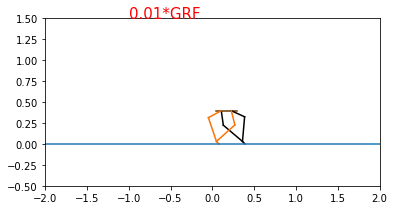

In [23]:
hide_sloution('Plot Solution')

#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_boom = {}
    plot_boom_COM = {}
    plot_UR = {}
    plot_LR = {}
    plot_UL = {}
    plot_LL = {}
    plot_foot = {}
    abs_angles = {}
    bod_angle = 0
    
    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(bod_angle)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - m.y_bodyOffset.value - 0.5*m.lengths['body']*sin(bod_angle)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(bod_angle)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value - m.y_bodyOffset.value + 0.5*m.lengths['body']*sin(bod_angle)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:brown')
    
#     # plot boom
#     plot_boom.update({('x_back'): 0.0})
#     plot_boom.update({('y_back'): m.y_bodyOffset.value})
#     plot_boom.update({('x_front'):m.q[i,'x_body'].value })
#     plot_boom.update({('y_front'):m.q[i,'y_body'].value })  
#     ax.plot([plot_boom['x_back'],plot_boom['x_front']],[plot_boom['y_back'],plot_boom['y_front']],color='xkcd:black')

#     # plot boom COM
#     plot_boom_COM.update({('x'): (m.cg.value/m.lx_boom.value)*m.q[i,'x_body'].value})
#     plot_boom_COM.update({('y'): (m.cg.value/m.ly_boom.value)*m.q[i,'y_body'].value})
#     ax.plot([plot_boom_COM['x']],[plot_boom_COM['y']],color='xkcd:purple',marker="o")

    for leg in legs:
        if leg == 'A':
            link_colour = ['black','red']
        else:
            link_colour = ['orange','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): bod_angle + m.q[i,'theta_UR'+leg].value})
        plot_UR.update({('top','X',leg): m.q[i,'x_body'].value + m.BLD.value*cos(bod_angle)})
        plot_UR.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value + m.BLD.value*sin(bod_angle)})
        plot_UR.update({('bot','X',leg): plot_UR['top','X',leg] - m.lengths['UR'+leg]*cos(abs_angles['RU',leg])})
        plot_UR.update({('bot','Y',leg): plot_UR['top','Y',leg] - m.lengths['UR'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_UR['top','X',leg],plot_UR['bot','X',leg]],[plot_UR['top','Y',leg],plot_UR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_LR'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_LR.update({('top','X',leg): plot_UR['bot','X',leg]})
        plot_LR.update({('top','Y',leg): plot_UR['bot','Y',leg]})
        plot_LR.update({('bot','X',leg): plot_UR['bot','X',leg] - m.lengths['LR'+leg]*cos(abs_angles['RL',leg])})
        plot_LR.update({('bot','Y',leg): plot_UR['bot','Y',leg] - m.lengths['LR'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_LR['top','X',leg],plot_LR['bot','X',leg]],[plot_LR['top','Y',leg],plot_LR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot foot
        plot_foot.update({('top','X',leg): plot_LR['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_LR['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_LR['bot','X',leg] + m.foot_length.value*cos(m.foot_angle.value - (np.pi)/2)})
        plot_foot.update({('bot','Y',leg): plot_LR['bot','Y',leg] - m.foot_length.value*sin(m.foot_angle.value - (np.pi)/2)})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): bod_angle + m.q[i,'theta_UL'+leg].value})
        plot_UL.update({('top','X',leg): m.q[i,'x_body'].value - m.BLD.value*cos(bod_angle)})
        plot_UL.update({('top','Y',leg): m.q[i,'y_body'].value - m.y_bodyOffset.value - m.BLD.value*sin(bod_angle)})
        plot_UL.update({('bot','X',leg): plot_UL['top','X',leg] - m.lengths['UL'+leg]*cos(abs_angles['LU',leg])})
        plot_UL.update({('bot','Y',leg): plot_UL['top','Y',leg]- m.lengths['UL'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_UL['top','X',leg],plot_UL['bot','X',leg]],[plot_UL['top','Y',leg],plot_UL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_LL'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_LL.update({('top','X',leg): plot_UL['bot','X',leg]})
        plot_LL.update({('top','Y',leg): plot_UL['bot','Y',leg]})
        plot_LL.update({('bot','X',leg): plot_UL['bot','X',leg] - m.lengths['LL'+leg]*cos(abs_angles['LL',leg])})
        plot_LL.update({('bot','Y',leg): plot_UL['bot','Y',leg] - m.lengths['LL'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_LL['top','X',leg],plot_LL['bot','X',leg]],[plot_LL['top','Y',leg],plot_LL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
    
    if m.GRF_y[i,'A'].value > 0.0:
        ax.arrow(plot_LL['bot','X','A'], plot_LL['bot','Y','A'], 0, 0.01*m.GRF_y[i,'A'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'B'].value > 0.0:
        ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_y[i,'B'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
#     if m.GRF_x[i,'-ve','B'].value > 0.0:
#         #print('GRF_footL = ',m.GRF_y[i,'footL'].value)
#         ax.arrow(plot_LR['bot','X','B'], plot_LR['bot','Y','B'], 0, 0.01*m.GRF_x[i,'-ve','B'].value,color='xkcd:{0}'.format('blue'),head_width = 0.1)
    
    
    #ax.legend(["GRF*0.01"], frameon=True)
    ax.text(x_low_lim, y_high_lim, '0.01*GRF', color = 'red',fontsize = 15)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [24]:
fileName = test+'_'+str(mu_value)+'_'+str(N)
f = r"{0}_biped.mp4".format(fileName) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 

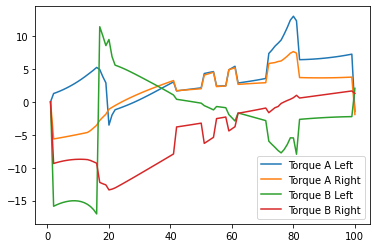

In [31]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.tau_torque[n,'left','A'].value)
    RightA.append(m.tau_torque[n,'right','A'].value)
    LeftB.append(m.tau_torque[n,'left','B'].value)
    RightB.append(m.tau_torque[n,'right','B'].value)
    
line1 = plt.plot(x,LeftA,label = 'Torque A Left')
line2 = plt.plot(x,LeftB,label = 'Torque A Right')
line3 = plt.plot(x,RightA,label = 'Torque B Left')
line4 = plt.plot(x,RightB,label = 'Torque B Right')
plt.legend()

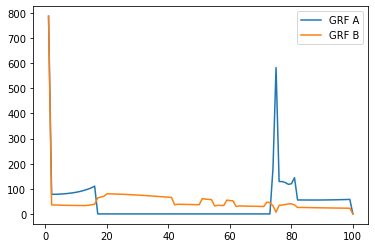

In [26]:
x = np.arange(1,N+1,1)
GRF_yA = []
GRF_yB = []


for n in range(1,N+1):
    GRF_yA.append(m.GRF_y[n,'A'].value)
    GRF_yB.append(m.GRF_y[n,'B'].value)
    
line1 = plt.plot(x,GRF_yA,label = 'GRF A')
line2 = plt.plot(x,GRF_yB,label = 'GRF B')

plt.legend()

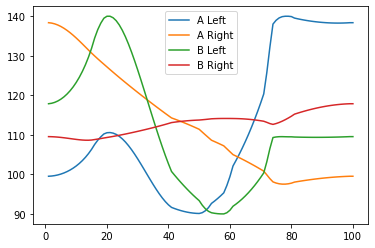

In [27]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.knee_angle[n,'left','A'].value*180/np.pi)
    RightA.append(m.knee_angle[n,'right','A'].value*180/np.pi)
    LeftB.append(m.knee_angle[n,'left','B'].value*180/np.pi)
    RightB.append(m.knee_angle[n,'right','B'].value*180/np.pi)
    
line1 = plt.plot(x,LeftA,label = 'A Left')
line2 = plt.plot(x,LeftB,label = 'A Right')
line3 = plt.plot(x,RightA,label = 'B Left')
line4 = plt.plot(x,RightB,label = 'B Right')
plt.legend()

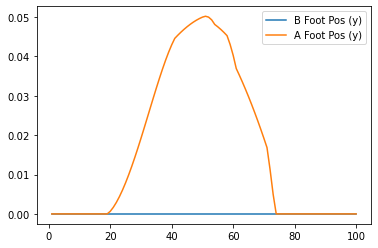

In [28]:
bGRFy = []
bFootPos = []
aGRFy = []
aFootPos = []
footScale = 1

for n in range(1,N+1):
    bGRFy.append(m.GRF_y[n,'B'].value)
    bFootPos.append(m.foot_position[n,'Y','B'].value*footScale)
    aGRFy.append(m.GRF_y[n,'A'].value)
    aFootPos.append(m.foot_position[n,'Y','A'].value*footScale)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootPos,label = 'B Foot Pos (y)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootPos,label = 'A Foot Pos (y)')
plt.legend()

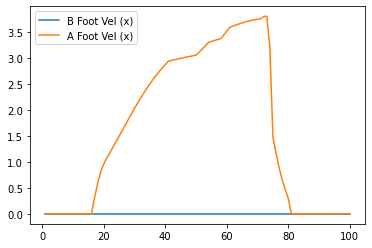

In [29]:
bFootVel = []
aFootVel = []

for n in range(1,N+1):
    bFootVel.append( m.foot_velocity[n,'X','+ve','B'].value-m.foot_velocity[n,'X','-ve','B'].value)
    aFootVel.append(m.foot_velocity[n,'X','+ve','A'].value-m.foot_velocity[n,'X','-ve','A'].value)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootVel,label = 'B Foot Vel (x)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootVel,label = 'A Foot Vel (x)')
plt.legend()

loop =  0
loop =  1
loop =  2
loop =  3
loop =  4


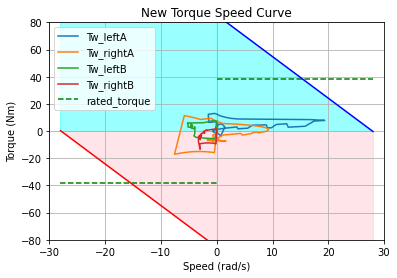

In [34]:
saveFile = True
loops = 5

if saveFile == True:
    fileName = test+'_'+str(N)
    f = r"{0}_biped.mp4".format(fileName) 
    writervideo = ani.FFMpegWriter(fps=20) 
    animate.save(f, writer=writervideo) 

    nodes = []

    xbody = []
    ybody = []
    thULA = []
    thURA = []
    thLLA = []
    thLRA = []
    thULB = []
    thURB = []
    thLLB = []
    thLRB = []



    dxbody = []
    dybody = []
    dthULA = []
    dthURA = []
    dthLLA = []
    dthLRA = []
    dthULB = []
    dthURB = []
    dthLLB = []
    dthLRB = []

    ddxbody = []
    ddybody = []
    ddthULA = []
    ddthURA = []
    ddthLLA = []
    ddthLRA = []
    ddthULB = []
    ddthURB = []
    ddthLLB = []
    ddthLRB = []

    Torque_leftA = []
    Torque_rightA = []
    Torque_leftB = []
    Torque_rightB = []

    GRF_y_A = []
    GRF_y_B = []
    foot_position_Y_A = []
    foot_position_Y_B = []

    angular_speed_leftA = []
    angular_speed_rightA = []
    angular_speed_leftB = []
    angular_speed_rightB = []



    for n in range(1,N+1):

        xbody.append(m.q[n,'x_body'].value)
        ybody.append(m.q[n,'y_body'].value)
        thULA.append(m.q[n,'theta_ULA'].value) 
        thURA.append(m.q[n,'theta_URA'].value) 
        thLLA.append(m.q[n,'theta_LLA'].value) 
        thLRA.append(m.q[n,'theta_LRA'].value) 
        thULB.append(m.q[n,'theta_ULB'].value) 
        thURB.append(m.q[n,'theta_URB'].value) 
        thLLB.append(m.q[n,'theta_LLB'].value) 
        thLRB.append(m.q[n,'theta_LRB'].value) 

        dxbody.append(m.dq[n,'x_body'].value)
        dybody.append(m.dq[n,'y_body'].value)
        dthULA.append(m.dq[n,'theta_ULA'].value) 
        dthURA.append(m.dq[n,'theta_URA'].value) 
        dthLLA.append(m.dq[n,'theta_LLA'].value) 
        dthLRA.append(m.dq[n,'theta_LRA'].value) 
        dthULB.append(m.dq[n,'theta_ULB'].value) 
        dthURB.append(m.dq[n,'theta_URB'].value) 
        dthLLB.append(m.dq[n,'theta_LLB'].value) 
        dthLRB.append(m.dq[n,'theta_LRB'].value) 

        ddxbody.append(m.ddq[n,'x_body'].value)
        ddybody.append(m.ddq[n,'y_body'].value)
        ddthULA.append(m.ddq[n,'theta_ULA'].value) 
        ddthURA.append(m.ddq[n,'theta_URA'].value) 
        ddthLLA.append(m.ddq[n,'theta_LLA'].value) 
        ddthLRA.append(m.ddq[n,'theta_LRA'].value) 
        ddthULB.append(m.ddq[n,'theta_ULB'].value) 
        ddthURB.append(m.ddq[n,'theta_URB'].value) 
        ddthLLB.append(m.ddq[n,'theta_LLB'].value) 
        ddthLRB.append(m.ddq[n,'theta_LRB'].value) 

        Torque_leftA.append(m.tau_torque[n,'left','A'].value)
        Torque_rightA.append(m.tau_torque[n,'right','A'].value)
        Torque_leftB.append(m.tau_torque[n,'left','B'].value)
        Torque_rightB.append(m.tau_torque[n,'right','B'].value)

        GRF_y_A.append(m.GRF_y[n,'A'].value)
        GRF_y_B.append(m.GRF_y[n,'B'].value)

        foot_position_Y_A.append(m.foot_position[n,'Y','A'].value)
        foot_position_Y_B.append(m.foot_position[n,'Y','B'].value)

        angular_speed_leftA.append(m.tau_velocity[n,'left','A'].value) 
        angular_speed_rightA.append(m.tau_velocity[n,'right','A'].value)
        angular_speed_leftB.append(m.tau_velocity[n,'left','B'].value)
        angular_speed_rightB.append(m.tau_velocity[n,'right','B'].value)

        nodes.append(n)

        pass



    ''' Store first values in csv file '''
    import csv
    # csv_file_name = str(int(V_avg))+'_u{0}'.format(mu_value)
    csv_file_name = "Test_{0}_N_{1}".format(test,N)

    heading0 = ['node']
    heading1 = ['x_body','y_body','theta_ULA','theta_URA','theta_LLA','theta_LRA','theta_ULB','theta_URB','theta_LLB','theta_LRB']
    heading2 = ['dx_body','dy_body','dtheta_ULA','dtheta_URA','dtheta_LLA','dtheta_LRA','dtheta_ULB','dtheta_URB','dtheta_LLB','dtheta_LRB']
    heading3 = ['ddx_body','ddy_body','ddtheta_ULA','ddtheta_URA','ddtheta_LLA','ddtheta_LRA','ddtheta_ULB','ddtheta_URB','ddtheta_LLB','ddtheta_LRB']
    heading4 = ['Tau_leftA','Tau_rightA','Tau_leftB','Tau_rightB', 'GRF_yA','GRF_yB']
    heading5 = ['foot_position_Y_A','foot_position_Y_B']
    heading = heading0 + heading1 + heading2 + heading3 + heading4 + heading5

    with open(csv_file_name+'.csv', 'w') as f:
        writer = csv.writer(f)

        writer.writerow(heading)
        
        for repeat in range(0,loops): 
            print('loop = ',repeat)
            for n in range(2*N*repeat,N*(2*repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-1
                # 0 - 50 cycle
                data1 = [xbody[n],ybody[n],thULA[n],thURA[n],thLLA[n],thLRA[n],thULB[n],thURB[n],thLLB[n],thLRB[n]]
                data2 = [dxbody[n],dybody[n],dthULA[n],dthURA[n],dthLLA[n],dthLRA[n],dthULB[n],dthURB[n],dthLLB[n],dthLRB[n]]
                data3 = [ddxbody[n],ddybody[n],ddthULA[n],ddthURA[n],ddthLLA[n],ddthLRA[n],ddthULB[n],ddthURB[n],ddthLLB[n],ddthLRB[n]]
                data4 = [Torque_leftA[n],Torque_rightA[n],Torque_leftB[n],Torque_rightB[n],GRF_y_A[n],GRF_y_B[n]]
                data5 = [foot_position_Y_A[n],foot_position_Y_B[n]]
                data = node + data1 + data2 + data3 + data4 + data5
                writer.writerow(data)

            for n in range(N*(2*repeat+1),2*N*(repeat+1)):
                node = [n+1]
                n = n+1-repeat*N*2-N-1
                # 50 - 100 cycle
                data1 = [xbody[n],ybody[n],thULB[n],thURB[n],thLLB[n],thLRB[n],thULA[n],thURA[n],thLLA[n],thLRA[n]]
                data2 = [dxbody[n],dybody[n],dthULB[n],dthURB[n],dthLLB[n],dthLRB[n],dthULA[n],dthURA[n],dthLLA[n],dthLRA[n]]
                data3 = [ddxbody[n],ddybody[n],ddthULB[n],ddthURB[n],ddthLLB[n],ddthLRB[n],ddthULA[n],ddthURA[n],ddthLLA[n],ddthLRA[n]]
                data4 = [Torque_leftB[n],Torque_rightB[n],Torque_leftA[n],Torque_rightA[n],GRF_y_B[n],GRF_y_A[n]]
                data5 = [foot_position_Y_B[n],foot_position_Y_A[n]]
                data = node + data1 + data2 + data3 + data4 + data5
                writer.writerow(data)
                
            
    
    plt.figure()
    plt.plot(angular_speed_leftA,Torque_leftA)
    plt.plot(angular_speed_rightA,Torque_rightA)
    plt.plot(angular_speed_leftB,Torque_leftB)
    plt.plot(angular_speed_rightB,Torque_rightB)

    plt.grid()
    plt.plot(x_p,rated_torque_p,color = 'green',linestyle = '--')
    plt.plot(x_n,rated_torque_n,color = 'green',linestyle = '--')

    plt.plot(x_p, y_p,'b')
    plt.plot(x_n, stall_torque_p,'b')

    plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
    plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

    plt.plot(x_n, y_n,'r')
    plt.plot(x_p, stall_torque_n,'r')

    plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
    plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

    plt.axis((-30,30,-80,80))
    plt.title('New Torque Speed Curve')
    plt.xlabel('Speed (rad/s)')
    plt.ylabel('Torque (Nm)')
    plt.legend(["Tw_leftA", "Tw_rightA","Tw_leftB", "Tw_rightB","rated_torque"], loc=0, frameon=True)
else:
    pass

In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[1,'y_body'].value,
             'dybod' : m.dq[1,'y_body'].value,
        'dxbod' : m.dq[1,'x_body'].value,
             
        'thULA' : m.q[1,'theta_ULA'].value,
        'thLLA' : m.q[1,'theta_LLA'].value,
        'thURA' : m.q[1,'theta_URA'].value,
        'thLRA' : m.q[1,'theta_LRA'].value,

        'thULB' : m.q[1,'theta_ULB'].value,
        'thLLB' : m.q[1,'theta_LLB'].value,
        'thURB' : m.q[1,'theta_URB'].value,
        'thLRB' : m.q[1,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[1,'theta_ULA'].value,
        'dthLLA' : m.dq[1,'theta_LLA'].value,
        'dthURA' : m.dq[1,'theta_URA'].value,
        'dthLRA' : m.dq[1,'theta_LRA'].value,

        'dthULB' : m.dq[1,'theta_ULB'].value,
        'dthLLB' : m.dq[1,'theta_LLB'].value,
        'dthURB' : m.dq[1,'theta_URB'].value,
        'dthLRB' : m.dq[1,'theta_LRB'].value}
    with open('periodic_walk_N1_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)



In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[N,'y_body'].value,
             'dybod' : m.dq[N,'y_body'].value,
        'dxbod' : m.dq[N,'x_body'].value,
             
        'thULA' : m.q[N,'theta_ULA'].value,
        'thLLA' : m.q[N,'theta_LLA'].value,
        'thURA' : m.q[N,'theta_URA'].value,
        'thLRA' : m.q[N,'theta_LRA'].value,

        'thULB' : m.q[N,'theta_ULB'].value,
        'thLLB' : m.q[N,'theta_LLB'].value,
        'thURB' : m.q[N,'theta_URB'].value,
        'thLRB' : m.q[N,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[N,'theta_ULA'].value,
        'dthLLA' : m.dq[N,'theta_LLA'].value,
        'dthURA' : m.dq[N,'theta_URA'].value,
        'dthLRA' : m.dq[N,'theta_LRA'].value,

        'dthULB' : m.dq[N,'theta_ULB'].value,
        'dthLLB' : m.dq[N,'theta_LLB'].value,
        'dthURB' : m.dq[N,'theta_URB'].value,
        'dthLRB' : m.dq[N,'theta_LRB'].value}
    with open('periodic_walk_finalN_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)